# TALLER 2 
**ESTUDIANTES:** 

Adriana Garcia Londoño (a-garcial@javeriana.edu.co) 

Mauricio Cardenas (m_cardenas@javeriana.edu.co)

In [1]:
#Manejo de matrices y tablas
import numpy as np
import pandas as pd

#Estadistica y funciones matemáticas
import scipy.stats as st
from scipy.optimize import fmin
from scipy import integrate
from scipy.stats.mstats import mquantiles


#Probabilistic programs
import pymc3 as pm
import theano.tensor as tt #NOTA: theano va a cambiar a tensorflow en PyMC4
from theano.compile.ops import as_op
print('Running on PyMC3 v{}'.format(pm.__version__))

#Graficas
import seaborn as sns
import plotly.graph_objects as go
import altair as alt
from altair_saver import save #ademas instalar en terminal: brew cask install chromedriver
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from matplotlib import animation, rc
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, HBox, VBox, Layout
from graphviz import Source, Digraph
import dot2tex as d2t
from latex import build_pdf
from mpl_toolkits.mplot3d import axes3d
import arviz as az

Running on PyMC3 v3.11.2


## EJERCICIO 1 - MODELOS DOT.

In [2]:
#Primero definamos la gráfica
dot_text = 'digraph G {\
                     node[margin=0.2, shape=rectangle,\
                          style = rounded,\
                          width=0.8, height = .7];\
                     compound=true;\
                     newrank=true;\
                     a -> b [label=" "];\
                     b -> c [label=" "];\
                     subgraph cluster0{\
                        label = " ";\
                        label = "$i people$";\
                        labeljust = "l";  color = "red";\
                        a;\
                        b;\
                        c;\
                     };\
                     d -> c;\
                     f -> b;\
                     e -> b;\
                     a [label = "z_i", shape = square,\
                                  width = 0.6];\
                     b [label = "$theta$",\
                                  shape = circle, peripheries = 2,width = 0.3];\
                     c [label = "k_i", shape = square,\
                                  width = 0.6];\
                     d [label = "$n$"shape = square,\
                                  width = 0.6];\
                     e [label = "$phi o$", fixedsize=true, width=0.5,\
                                 shape = circle];\
                     f [label = "$psi w$", shape = circle,\
                                  width = 0.6 ];\
                     }' 


In [3]:
#Tip: use single quote at start and end; double quotes for labels
#Ahora salvarla
s = Source(dot_text, filename="img1/4_CB/tutorial_dot.gv", format="svg") #THIS IS NOT THE FINAL ONE
s.view()

'img1/4_CB\\tutorial_dot.gv.svg'

In [4]:
ppe = 5/11

e1 = ppe 

#El de abajo no me cargo, no estaba en la carpeta principal que me mandaron.

### GRAFICO EN draw.io

<center><img src="myfirstdiagram.svg" width = "800" height = '800'></center>

Grafico Usando la aplicacion https://app.diagrams.net/


<center><img src="myfirstdiagram2.svg" width = "800" height = '800'></center>

Grafico Usando la aplicacion https://app.diagrams.net/

## EJERCICIO 2: Cambio de Frecuencia de los mensajes de texto

### PARTE 1: Preambulo del modelo

In [5]:
count_data = np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)
dias = np.linspace(1, n_count_data, num = n_count_data, dtype = int)

In [6]:
# Primero definamos constantes y variables deterministicas
alpha = 1.0/count_data.mean()  # count_data holds our text counts.

# PyMC utiliza la clase `Model` para guardar el modelo
with pm.Model() as modelo_mensajes:
    
    ### Latentes
    lambda_antes = pm.Exponential("lambda_antes", lam = alpha) 
    lambda_despues = pm.Exponential("lambda_despues", lam = alpha)
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)
    #Siguiente línea: 
    #if primer argumento true, then tercero, else segundo
    lambda_usado = pm.math.switch(tau < dias, 
                                  lambda_despues, lambda_antes) 
    
    ### Likelihood    
    conteos = pm.Poisson("conteos", lambda_usado, 
                         observed=count_data)


In [7]:
#La variable model tiene toda la información 
#RV: random variables
print(modelo_mensajes.basic_RVs) #Todas 
print(modelo_mensajes.free_RVs) #Latentes / no observables
print(modelo_mensajes.observed_RVs) #Observables

#En prob. program. las variables son aleatorias (ejemplo)
rvs = modelo_mensajes.lambda_antes.random
print(np.round(rvs(),2), np.round(rvs(),2), np.round(rvs(),2))
modelo_mensajes.lambda_antes

[lambda_antes_log__ ~ TransformedDistribution, lambda_despues_log__ ~ TransformedDistribution, tau ~ DiscreteUniform, conteos ~ Poisson]
[lambda_antes_log__ ~ TransformedDistribution, lambda_despues_log__ ~ TransformedDistribution, tau ~ DiscreteUniform]
[conteos ~ Poisson]
16.38 10.6 10.21


lambda_antes ~ Exponential

In [8]:
with modelo_mensajes:
    trace = pm.sample(10000, chains = 4, cores = 2)
    #posterior_predictive = pm.sample_posterior_predictive(trace)

<ipython-input-8-1cf600fe060c>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000, chains = 4, cores = 2)
Multiprocess sampling (4 chains in 2 jobs)
CompoundStep
>NUTS: [lambda_despues, lambda_antes]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 22 seconds.
The number of effective samples is smaller than 25% for some parameters.


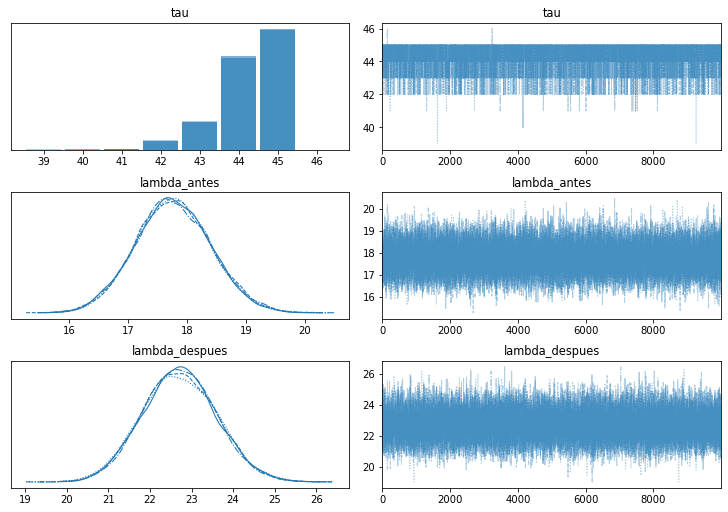

In [9]:
data = az.from_pymc3(
    trace=trace[0:10000], #1500 samples to keep the image file light
    model=modelo_mensajes,
)
az.plot_trace(data, figsize = [10,7]);

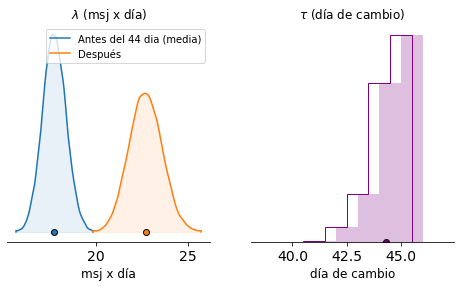

In [10]:
fig, ax = plt.subplots(1,2, figsize = [8,4])
dia = int(trace['tau'].mean())
az.plot_density(
    [trace['lambda_antes'], trace['lambda_despues']],
    data_labels=["Antes del " + str(dia) + " dia (media)", 
                 "Después"],
    shade=.1, ax = ax[0], hdi_prob=.999, 
)
az.plot_density(
    [trace['tau']], hdi_prob=.999,
    data_labels=["$\\tau$ (día) "], outline=True,
    shade=.25, ax = ax[1], colors = 'purple', 
)
ax[0].set_title('$\lambda$ (msj x día)', fontsize = 12)
ax[1].set_title('$\\tau$ (día de cambio)', fontsize = 12)
ax[0].set_xlabel('msj x día', fontsize = 12)
ax[1].set_xlabel('día de cambio', fontsize = 12)
ax[0].legend(loc='upper right')

In [11]:
promedio_conteo = np.zeros_like(count_data, dtype='float')
#High density interval
HDI95_conteo = np.zeros_like(count_data, dtype='float') 
HDI5_conteo = np.zeros_like(count_data, dtype='float')
for i, dia in enumerate(dias):
    #las muestras están ordenadas como el algoritmo las tomó
    idx = dia < trace['tau'] 
    antes = trace['lambda_antes'][idx] 
    despues = trace['lambda_despues'][~idx]
    HDI95_conteo[i] = np.percentile(
        np.concatenate((antes,despues)),97.5
    )
    HDI5_conteo[i] = np.percentile(
        np.concatenate((antes,despues)),2.5
    )
    promedio_conteo[i] = np.concatenate((antes,despues)).mean()


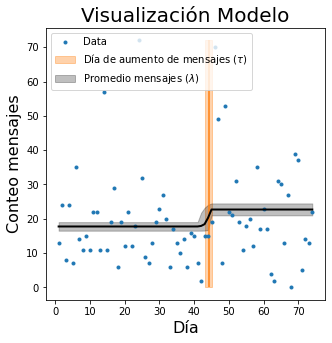

In [12]:
plt.figure(figsize=(5, 5)); 
plt.plot(dias, count_data, '.',  label = 'Data')
plt.ylabel("Conteo mensajes", fontsize=16); 
plt.xlabel("Día", fontsize=16)
plt.title("Visualización Modelo", fontsize=20)   
hdi = az.hdi(trace['tau']) #high density interval (calculado con Arviz; igual a np.percentile)
plt.vlines(trace['tau'].mean(), count_data.min(), count_data.max(), color='C1')
plt.fill_betweenx(y=[count_data.min(), count_data.max()],
                  x1=hdi[0], x2=hdi[1], alpha=0.35, color='C1',
                 label = 'Día de aumento de mensajes ($\\tau$)');
plt.fill_between(x=np.linspace(1, len(dias), HDI5_conteo.size), 
                 y1=HDI5_conteo, y2=HDI95_conteo, alpha=0.25, color='k',
                 label = 'Promedio mensajes ($\lambda$)');
plt.plot(dias, promedio_conteo,  'k', lw=2); 
plt.legend(loc = 'upper left')

100% seguros que msj x día (lambdas) difieren en el día del cambio


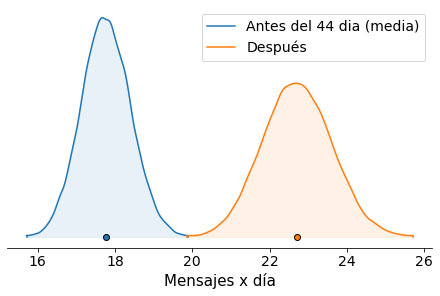

In [13]:
test = trace['lambda_antes']<trace['lambda_despues']
tA = str(int(test.mean()*100))
tB = "% seguros que msj x día (lambdas) difieren en el día del cambio"
print(tA + tB)
dia = int(trace['tau'].mean())
az.plot_density(
    [trace['lambda_antes'], trace['lambda_despues']],
    data_labels=["Antes del " + str(dia) + " dia (media)", 
                 "Después"],
    shade=.1, hdi_prob = .999, 
);
plt.xlabel('Mensajes x día', fontsize = 15)
plt.title("");

### PARTE 2: Ejercicios (mensajes de texto Poisson) 
**1.** Calcule el promedio de lambda_antes y lambda_despues.

In [14]:
mean_la=trace['lambda_antes'].mean()
mean_ld=trace['lambda_despues'].mean()
print('promedio lambda antes :' ,mean_la)
print('promedio lambda despues :' ,mean_ld)

promedio lambda antes : 17.76353268926279
promedio lambda despues : 22.707300740184227


In [15]:
#Forma pro
az.summary(trace,kind='stats')['mean']

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


tau               44.295
lambda_antes      17.764
lambda_despues    22.707
Name: mean, dtype: float64

In [16]:
e2 = ppe

**2.** Calcule el incremento porcentual promedio de mensajes por día. pista: Consiga la distribución de la variable incremento porcentual. No haga lambda_antes.mean()/lambda_despues.mean(). Es parecido, pero use todas las posteriores. Queremos el promedio de la distribución de incremento porcentual.

1.279957499170048

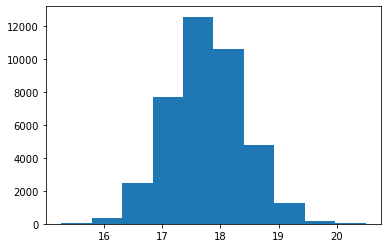

In [17]:
plt.hist(trace['lambda_antes'])
mean_p=trace['lambda_despues']/trace['lambda_antes']
mean_p.mean()

In [18]:
e3 = ppe

**3.** Calcule el promedio de  𝜆𝑎𝑛𝑡𝑒𝑠  dado que  𝜏<45 . Recuerde: las muestras del sampleador están coordinadas. Es decir, busque los indices de  𝜏  menores a 45 y use ese indice para seleccionar muestras de  𝜆𝑎𝑛𝑡𝑒𝑠 .

In [19]:
tau=45
bool_tau=trace['tau']<tau
trace['lambda_antes'][bool_tau]
print('Promedio lambda antes para tau<45:' ,trace['lambda_antes'][bool_tau].mean())

Promedio lambda antes para tau<45: 17.761313972157968


In [20]:
e4 = ppe

**4.** Modelos .dot

In [ ]:
#Primero definamos la gráfica
dot_text2 = 'digraph G {\
                     node[margin=0.2, shape=rectangle,\
                          style = rounded,\
                          width=0.8, height = .6];\
                     compound=true;\
                     newrank=true;\
                     subgraph cluster0{\
                        label = " ";\
                        label = "$i data$";\
                        labeljust = "l";  color = "black";\
                        d;\
                     };\
                     a -> d;\
                     b -> d;\
                     c -> d;\
                     a [label = "$\mu$", shape = circle,\
                                  width = 0.3];\
                     b [label = "$r$",\
                                  shape = circle,width = 0.3];\
                     c [label = "$\sigma$", shape = circle,\
                                  width = 0.3];\
                     d [label = "$x_i$",shape = circle,style=filled, fillcolor=gray,\
                                  width = 0.3];\
                     }' 


In [ ]:
#Tip: use single quote at start and end; double quotes for labels
#Ahora salvarla
s2 = Source(dot_text2, filename="img1/4_CB/tutorial_dot2.gv", format="svg") #THIS IS NOT THE FINAL ONE
s2.view()

## EJERCICIOS 3: Detector de Mentiras  

**Ejercicios**

**1.** Ponga valores extremos para el ejemplo de trampas. ¿Qué pasa si observamos 25 respuestas afirmativas? ¿10?¿50?

**2.** Cambie la moneda en el ejemplo de las trampas. Como la interpreta

**3.** Cambie los priors, que no sea uniforme, en el ejemplo de las trampas

### PARTE 1: Preambulo del modelo

In [21]:
prob_cara = 0.5
prob_sello = 0.5
with pm.Model() as tramposos_original:
    prob_trampa = pm.Uniform("prob_trampa", 0, 1) #Prior uniforme 
    prop_trampo = pm.Deterministic("prop_tramposos", prob_cara*prob_trampa + prob_sello*prob_cara)

In [22]:
N = 100 #Número de estudiantes
trampo = 35 #Número de reportes que dicen hacer trampa
with tramposos_original:
    tramposos = pm.Binomial("obs", N, prop_trampo, 
                            observed=trampo)

# Ya podemos samplear
with tramposos_original:
    step = pm.Metropolis(vars=[prob_trampa])
    trace = pm.sample(40000, step=step)
    burned_trace = trace[15000:]
    

<ipython-input-22-1c1c8c70ab42>:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(40000, step=step)
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [prob_trampa]


Sampling 4 chains for 1_000 tune and 40_000 draw iterations (4_000 + 160_000 draws total) took 44 seconds.
The number of effective samples is smaller than 25% for some parameters.


prob_trampa


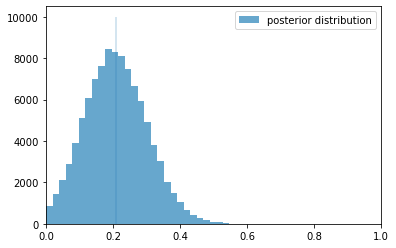

In [23]:
print("prob_trampa")
plt.hist(burned_trace["prob_trampa"], histtype="stepfilled", alpha=0.75, bins=30, 
         label="posterior distribution",color="#348ABD")
plt.vlines(burned_trace["prob_trampa"].mean(), 0, 10000, alpha=0.25)
plt.xlim(0.0, 1)
plt.legend();

prop_tramposos


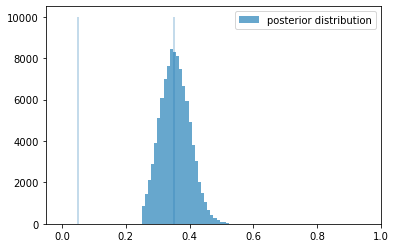

In [24]:
print("prop_tramposos")
p_trace = burned_trace["prop_tramposos"]
plt.hist(p_trace, histtype="stepfilled", alpha=0.75, bins=30, 
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [10000, 10000], alpha=0.35)
plt.xlim(-0.05, 1)
plt.legend();

In [25]:
#Forma pro
az.summary(burned_trace,kind='stats')

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%
prob_trampa     0.209  0.091   0.035    0.374
prop_tramposos  0.355  0.046   0.268    0.437

### PARTE 2: Ejercicios
#### 1. VALORES DE LOS DATOS- model_extreme
1. Ponga valores extremos para el ejemplo de trampas. ¿Qué pasa si observamos 25 respuestas afirmativas? ¿10?¿50?

- #### trampo=90
Note que este valor significa que en la encuesta realizada el 90% de los estudiantes (90/100) respondieron que son tramposos, ras lanzar la moneda justa. Luego lo que observamos es que en su mayoria *Los estudiantes dicen ser tramposos*

In [26]:
#Un valor extremo: Casi Todos dicen ser mentirosos (trampo=90)
prob_cara = 0.5
prob_sello = 0.5

with pm.Model() as tramposos_extreme:
    prob_trampa = pm.Uniform("prob_trampa", 0, 1) #Prior uniforme 
    prop_trampo = pm.Deterministic("prop_tramposos", prob_cara*prob_trampa + prob_sello*prob_cara)

In [27]:
N = 100 #Número de estudiantes
trampo = 90 #Número de reportes que dicen hacer trampa
with tramposos_extreme:
    tramposos = pm.Binomial("obs", N, prop_trampo,observed=trampo)

# Ya podemos samplear
with tramposos_extreme:
    step = pm.Metropolis(vars=[prob_trampa])
    trace_extreme = pm.sample(40000, step=step)
    burned_trace_extreme = trace_extreme[15000:]

<ipython-input-27-83b207fbec8c>:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_extreme = pm.sample(40000, step=step)
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [prob_trampa]


Sampling 4 chains for 1_000 tune and 40_000 draw iterations (4_000 + 160_000 draws total) took 44 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [28]:
#Forma pro
print('prob_trampa promedio es ', az.summary(burned_trace_extreme,kind='stats')['mean'][0] ,
      '\n y la proporcion media de tramsposos es',az.summary(burned_trace_extreme,kind='stats')['mean'][1] )
az.summary(burned_trace_extreme,kind='stats')

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


prob_trampa promedio es  0.977 
 y la proporcion media de tramsposos es 0.739


C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%
prob_trampa     0.977  0.022   0.937     1.00
prop_tramposos  0.739  0.011   0.718     0.75

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


El gráfico rojo corresponde a los valores calculados para la posterior en el caso extremo con trampo=90 
El gráfico azul corresponde a los valores calculados para la posterior en el caso original con trampo=35


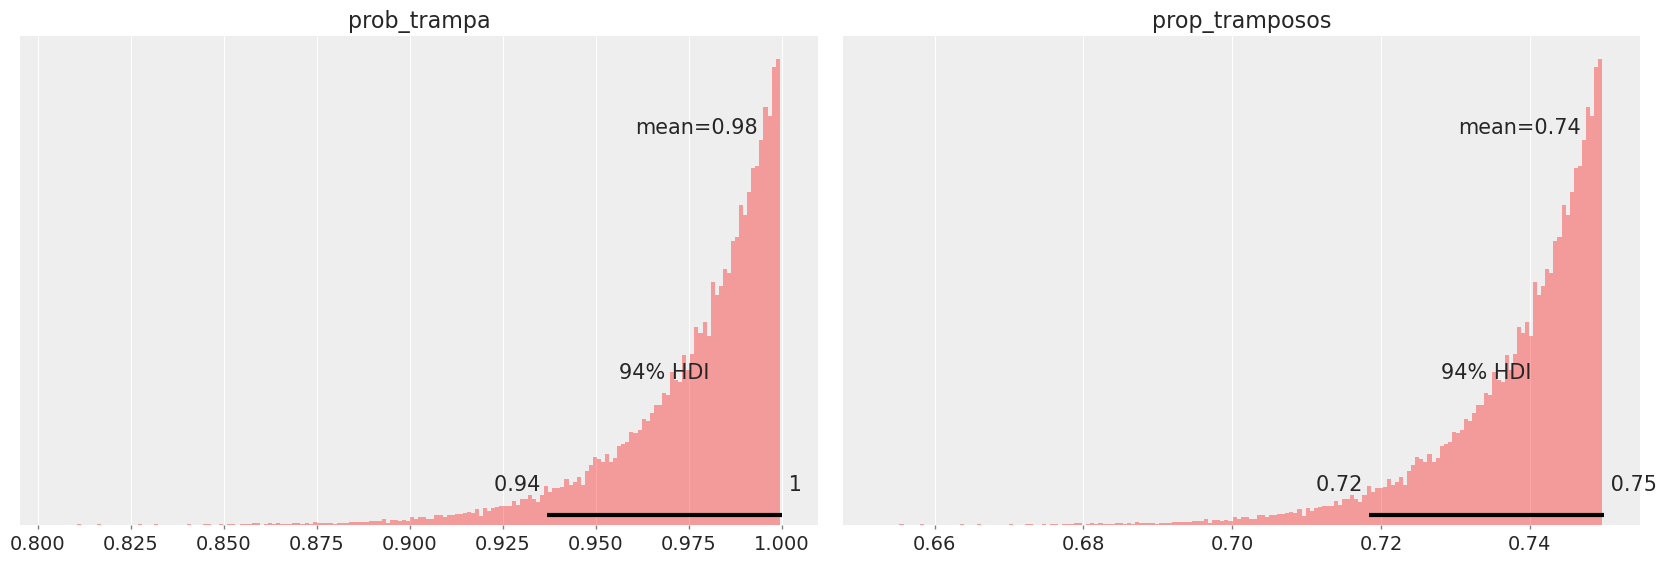

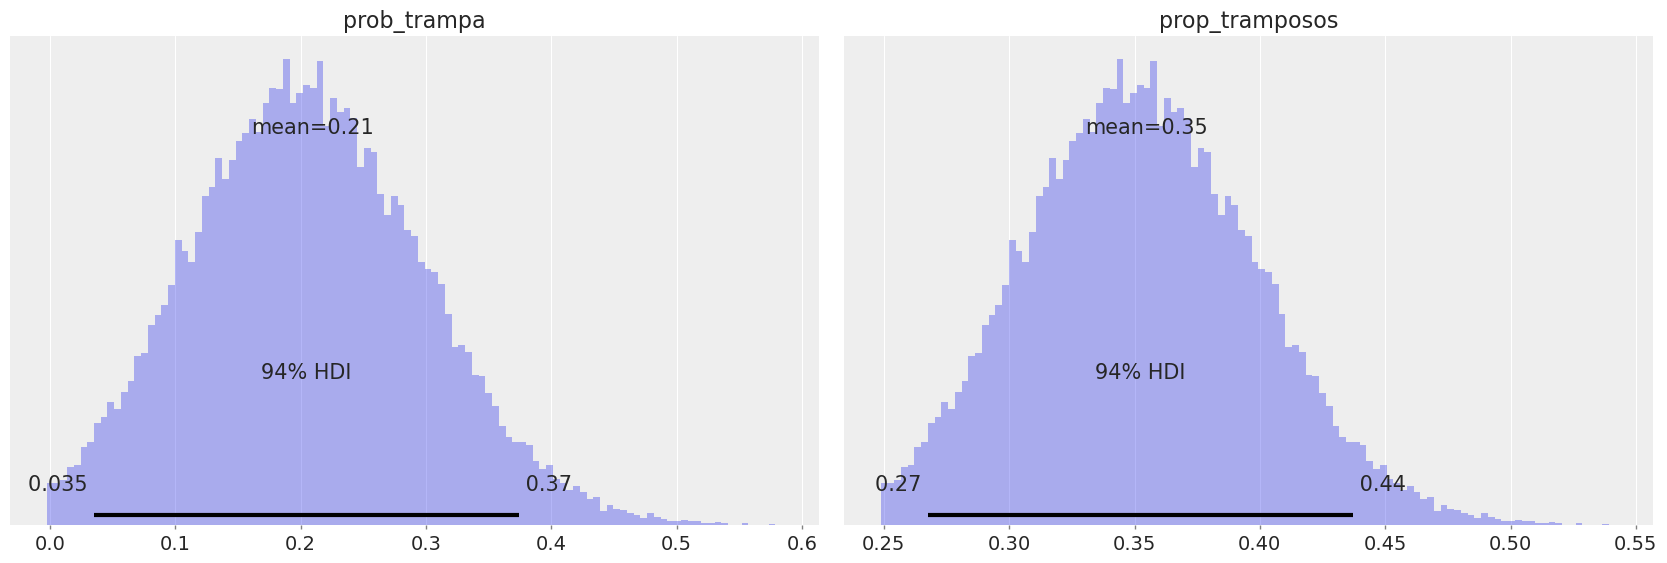

In [29]:
az.style.use("arviz-darkgrid")
az.plot_posterior(burned_trace_extreme,kind='hist',label='a',color="red")
az.plot_posterior(burned_trace,kind='hist')
print('El gráfico rojo corresponde a los valores calculados para la posterior en el caso extremo con trampo=90', 
      '\nEl gráfico azul corresponde a los valores calculados para la posterior en el caso original con trampo=35')

**CONLUSION**
Note que en este caso supusimos un valor extremo sobre las personas que respondieron la pregunta de ser tramposos dado la modeda justa, en donde 9 de cada 10 dijeron ser deshonestos. En este caso a diferencia del original en donde el valor promedio prop_tramposos=0.354 y la prob_tamposos=0.208, en este caso el valor promedio es casi 3 veces más alto para ambos parámetros. Esto tiene sentido, pues una vez vemos que la mayoria de estudiantes nos dicen que son deshonestos(tramposos) dado el lanzamiento de la moneda, nuestras hipotesis y su valor dados los observables se actualizan! Por esto vemos un desplazamiento de ammbos hiperparámetros hacia la derecha en sus distribuciones.

- #### trampo=10
Note que en este caso,  en la encuesta realizada el 10% de los estudiantes (10/100) respondieron que son tramposos. Luego lo que observamos es que en su mayoria *Los estudiantes dicen en su mayoria ser no tramposos*

In [34]:
#trampo=10: 
with pm.Model() as tramposos_10:
    prob_trampa = pm.Uniform("prob_trampa", 0, 1) #Prior uniforme 
    prop_trampo = pm.Deterministic("prop_tramposos", prob_cara*prob_trampa + prob_sello*prob_cara)


In [35]:
trampo = 10 #Número de reportes que dicen hacer trampa
with tramposos_10:
    tramposos = pm.Binomial("obs", N, prop_trampo,observed=trampo)

# Ya podemos samplear
with tramposos_10:
    step = pm.Metropolis(vars=[prob_trampa])
    trace_10 = pm.sample(10000, step=step)
    burned_trace_10 = trace_10[1500:]

<ipython-input-35-b5d8e8d9e37f>:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_10 = pm.sample(10000, step=step)
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [prob_trampa]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 22 seconds.
The number of effective samples is smaller than 25% for some parameters.


C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


trampo=10
                  mean     sd  hdi_3%  hdi_97%
prob_trampa     0.024  0.024    0.00    0.067
prop_tramposos  0.262  0.012    0.25    0.283


C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


El gráfico rojo corresponde a los valores calculados para la posterior en el caso extremo con trampo=10 
El gráfico azul corresponde a los valores calculados para la posterior en el caso original con trampo=35


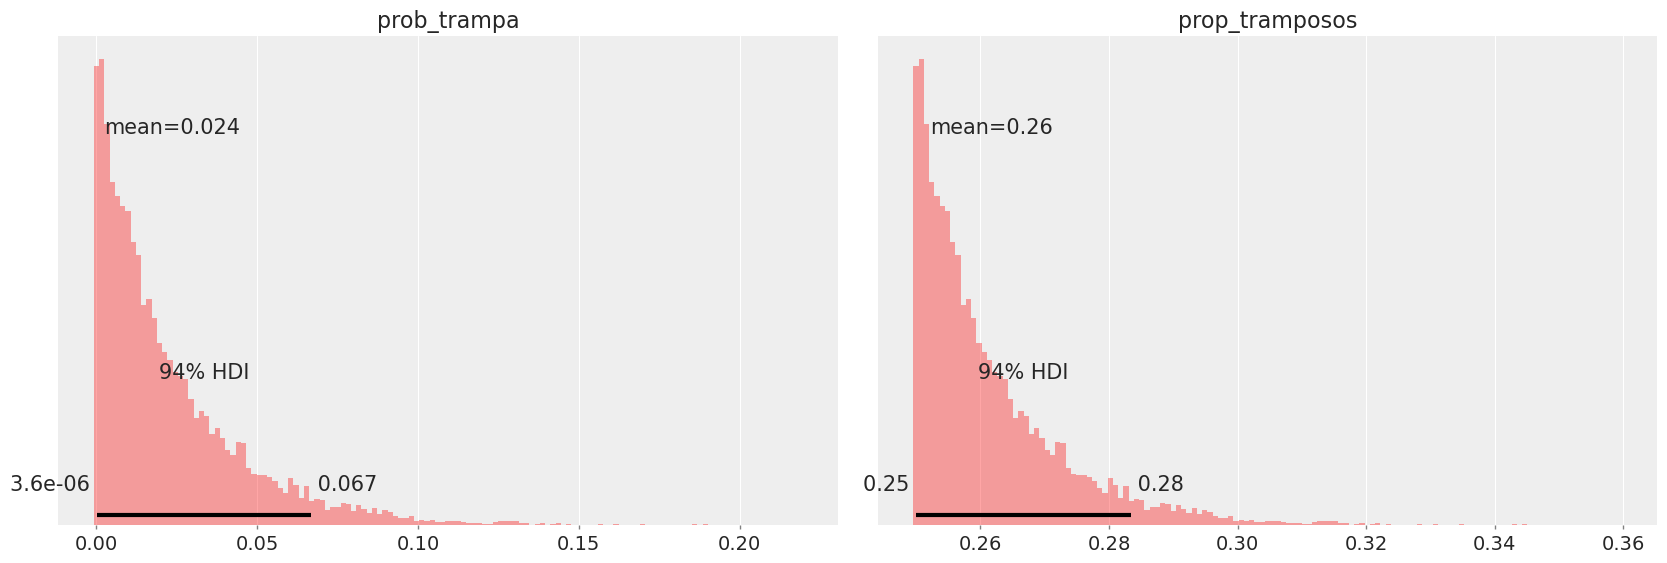

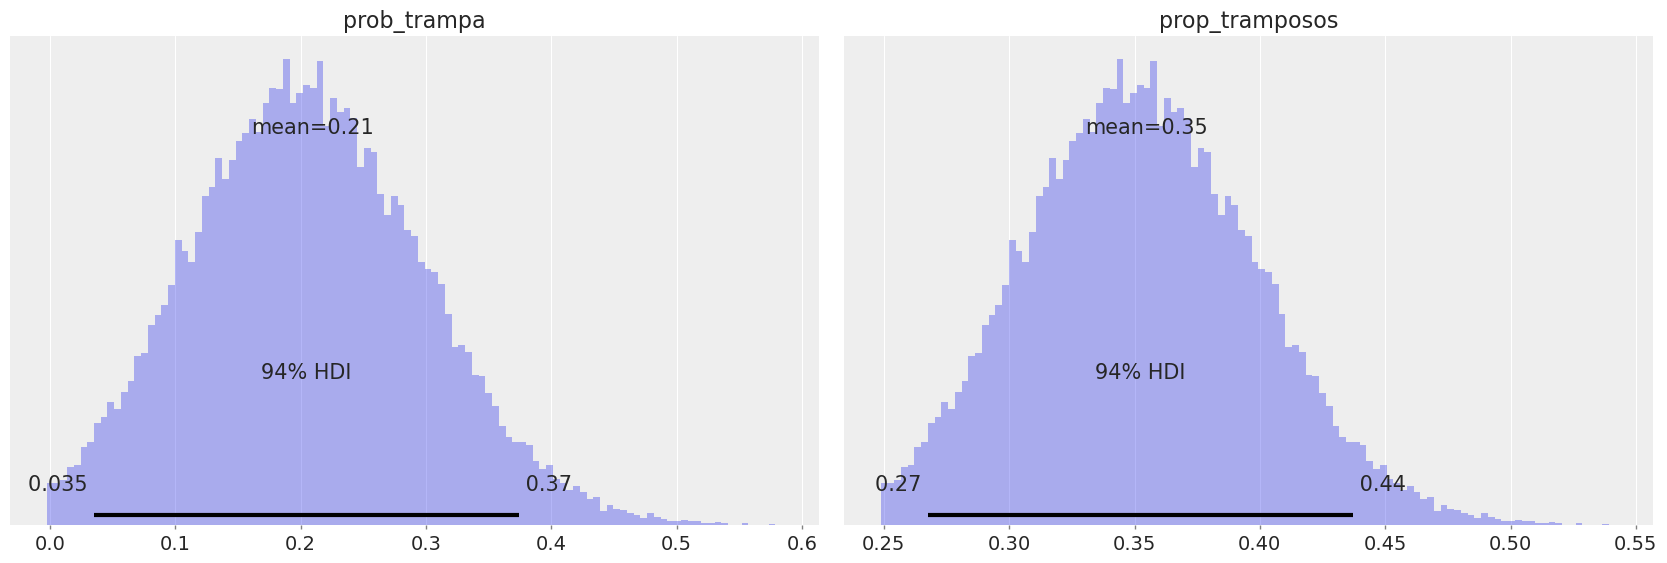

In [36]:
print('trampo=10\n',az.summary(burned_trace_10,kind='stats'))

#Forma pro
az.plot_posterior(burned_trace_10,kind='hist',color="red")
az.plot_posterior(burned_trace,kind='hist')
print('El gráfico rojo corresponde a los valores calculados para la posterior en el caso extremo con trampo=10', 
      '\nEl gráfico azul corresponde a los valores calculados para la posterior en el caso original con trampo=35')
az.style.use("arviz-darkgrid")

**CONLUSION**

A diferencia del caso original, note que ahora el valor medio de la prop_trampa en este caso se muestra no centrado sobre la media. Más aun tiene una clara asimetria. Note que ahora la prob de trampa promedio pasa de 0.21 a 0.023 y la prop de tramposos de 0.36 a 0.26.
Adicionalmente, dado que en las observaciones tenemos que una menor cantidad de estudiantes dicen ser tramposos,esto se traduce directamente al posterior de la proporción de tramposos y de la probabilidad de trampa. Ambas distribuciones presentan una media menor a la del caso original. Esto tiene sentido, pensemos por un momento que el día de mañana los estudiantes se vuelven más honestos y corremos el experimento en un nuevo curso (habiendo ajustado los observables), esto hace que deberiamos ajustar los hiperparámetros de nuestras hipótesis de dados los observables en los nuevos estudiantes, pensando que ahora la probabilidad de que sean deshonestos es menor (caso rojo).

- #### trampo=25 (tramposos_25)
Tomando los mismos valores para la moneda, y las distribuciones, simplemente cambiamos el parámetro trampo=25. En este caso observamos que el 25% de los estudiantes dicen ser deshonestos (Tramposos), tras el lanzamiento de la moneda justa

In [38]:
#trampo=25: tramposos_25
with pm.Model() as tramposos_25:
    prob_trampa = pm.Uniform("prob_trampa", 0, 1) #Prior uniforme 
    prop_trampo = pm.Deterministic("prop_tramposos", prob_cara*prob_trampa + prob_sello*prob_cara)

In [39]:
trampo = 25 #Número de reportes que dicen hacer trampa
with tramposos_25:
    tramposos = pm.Binomial("obs", N, prop_trampo,observed=trampo)

# Ya podemos samplear
with tramposos_25:
    step = pm.Metropolis(vars=[prob_trampa])
    trace_25 = pm.sample(10000, step=step)
    burned_trace_25 = trace_25[1500:]

<ipython-input-39-e0e72fa8dab8>:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_25 = pm.sample(10000, step=step)
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [prob_trampa]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 21 seconds.
The number of effective samples is smaller than 25% for some parameters.


C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


trampo=25
                  mean     sd  hdi_3%  hdi_97%
prob_trampa     0.075  0.056    0.00    0.176
prop_tramposos  0.287  0.028    0.25    0.338


C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


trampo=35
                  mean     sd  hdi_3%  hdi_97%
prob_trampa     0.209  0.091   0.035    0.374
prop_tramposos  0.355  0.046   0.268    0.437


C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


El gráfico rojo corresponde a los valores calculados para la posterior en el caso extremo con trampo=25 
El gráfico azul corresponde a los valores calculados para la posterior en el caso original con trampo=35


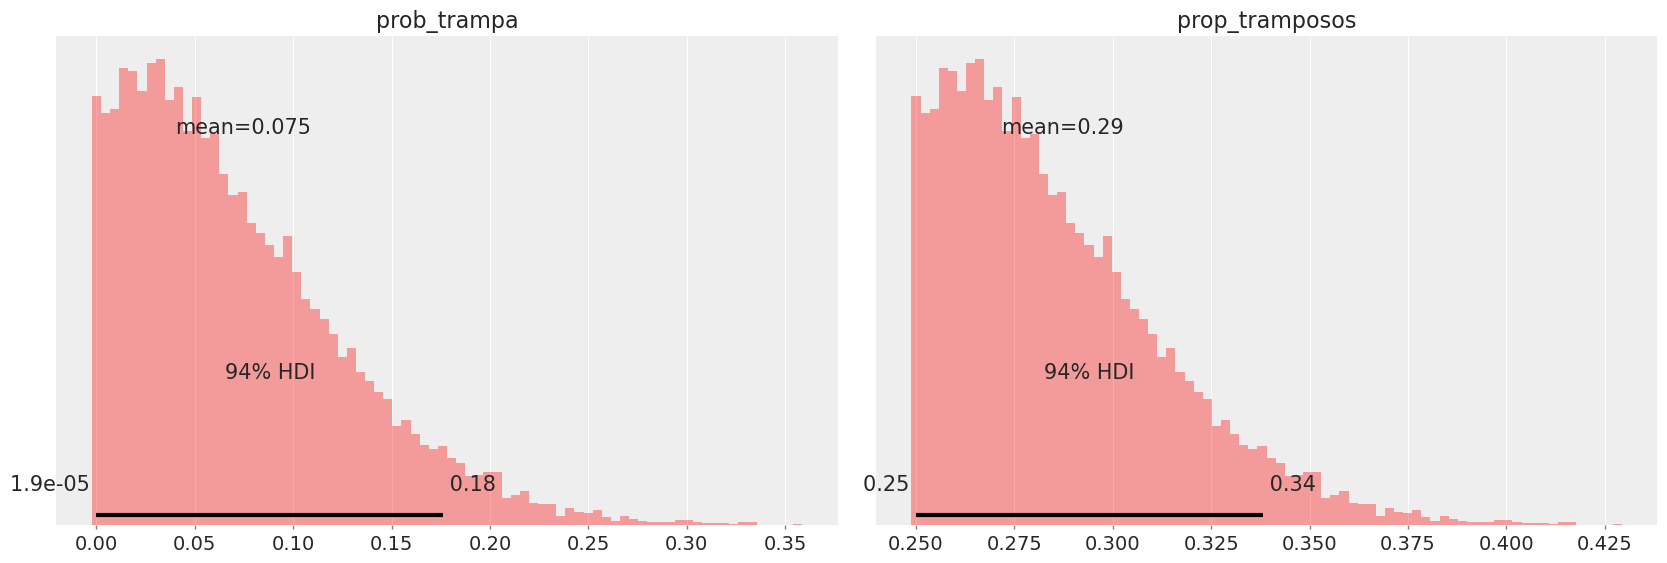

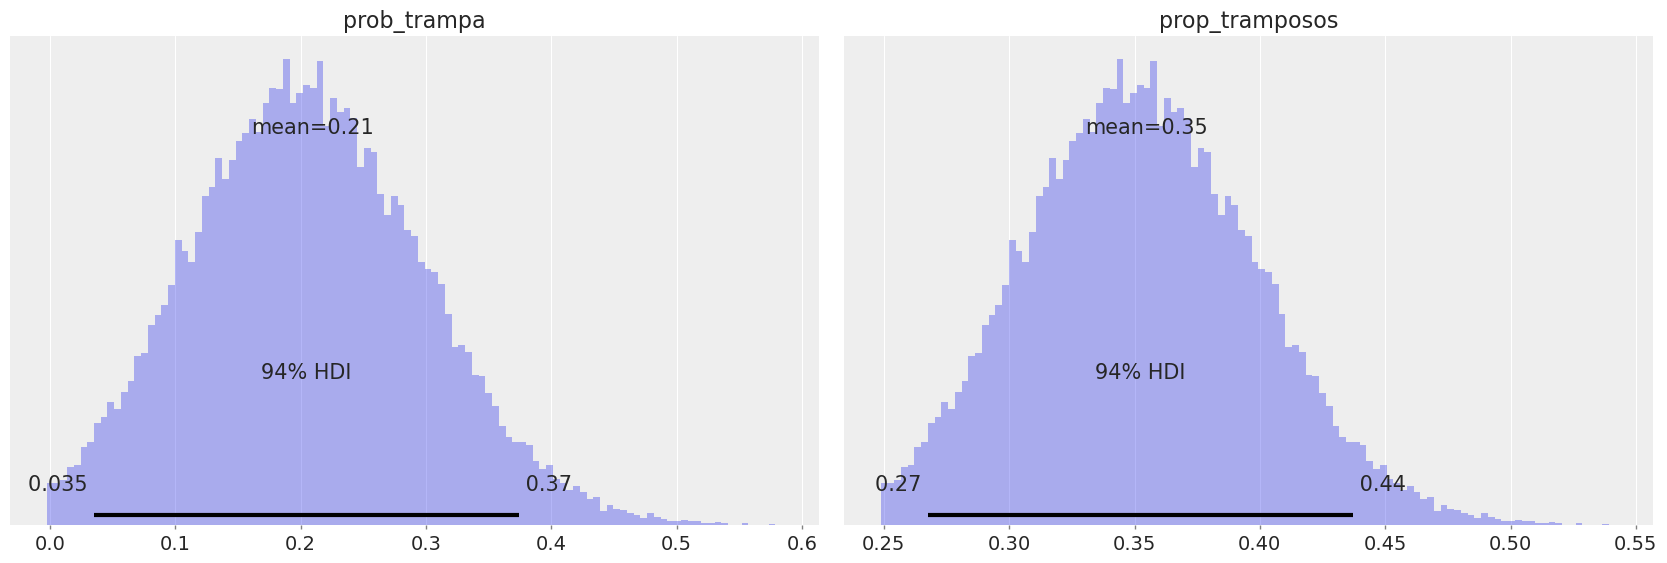

In [40]:
print('trampo=25\n',az.summary(burned_trace_25,kind='stats'))
print('trampo=35\n',az.summary(burned_trace,kind='stats'))
#Forma pro
az.plot_posterior(burned_trace_25,kind='hist',color="red")
az.plot_posterior(burned_trace,kind='hist')
print('El gráfico rojo corresponde a los valores calculados para la posterior en el caso extremo con trampo=25', 
      '\nEl gráfico azul corresponde a los valores calculados para la posterior en el caso original con trampo=35')
az.style.use("arviz-darkgrid")

**CONLUSION**
La distribución del posterior en este caso, aunque se ajusta a estar más cerca a los datos del caso orginal, aun presenta una menor tendencia a darnos valores de los hiperparametros para la distribución de prob_trampa y proprcion de tramposos como en el caso original. Aún la probabilildad de trampa es baja, solamente del 7% dados los observados.

- #### trampo=50 (tramposos_50)
Tomando los mismos valores para la moneda, y las distribuciones, simplemente cambiamos el parámetro trampo=50

In [42]:
#trampo=50
with pm.Model() as tramposos_50:
    prob_trampa = pm.Uniform("prob_trampa", 0, 1) #Prior uniforme 
    prop_trampo = pm.Deterministic("prop_tramposos", prob_cara*prob_trampa + prob_sello*prob_cara)

In [43]:
trampo = 50 #Número de reportes que dicen hacer trampa
with tramposos_50:
    tramposos = pm.Binomial("obs", N, prop_trampo,observed=trampo)

# Ya podemos samplear
with tramposos_50:
    step = pm.Metropolis(vars=[prob_trampa])
    trace_50 = pm.sample(10000, step=step)
    burned_trace_50 = trace_50[1500:]

<ipython-input-43-48fbdc8312d0>:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_50 = pm.sample(10000, step=step)
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [prob_trampa]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 22 seconds.
The number of effective samples is smaller than 25% for some parameters.


C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


trampo=50
                  mean     sd  hdi_3%  hdi_97%
prob_trampa     0.498  0.098   0.317    0.685
prop_tramposos  0.499  0.049   0.409    0.593


C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


trampo=35
                  mean     sd  hdi_3%  hdi_97%
prob_trampa     0.209  0.091   0.035    0.374
prop_tramposos  0.355  0.046   0.268    0.437


C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


El gráfico rojo corresponde a los valores calculados para la posterior en el caso extremo con trampo=50 
El gráfico azul corresponde a los valores calculados para la posterior en el caso original con trampo=35


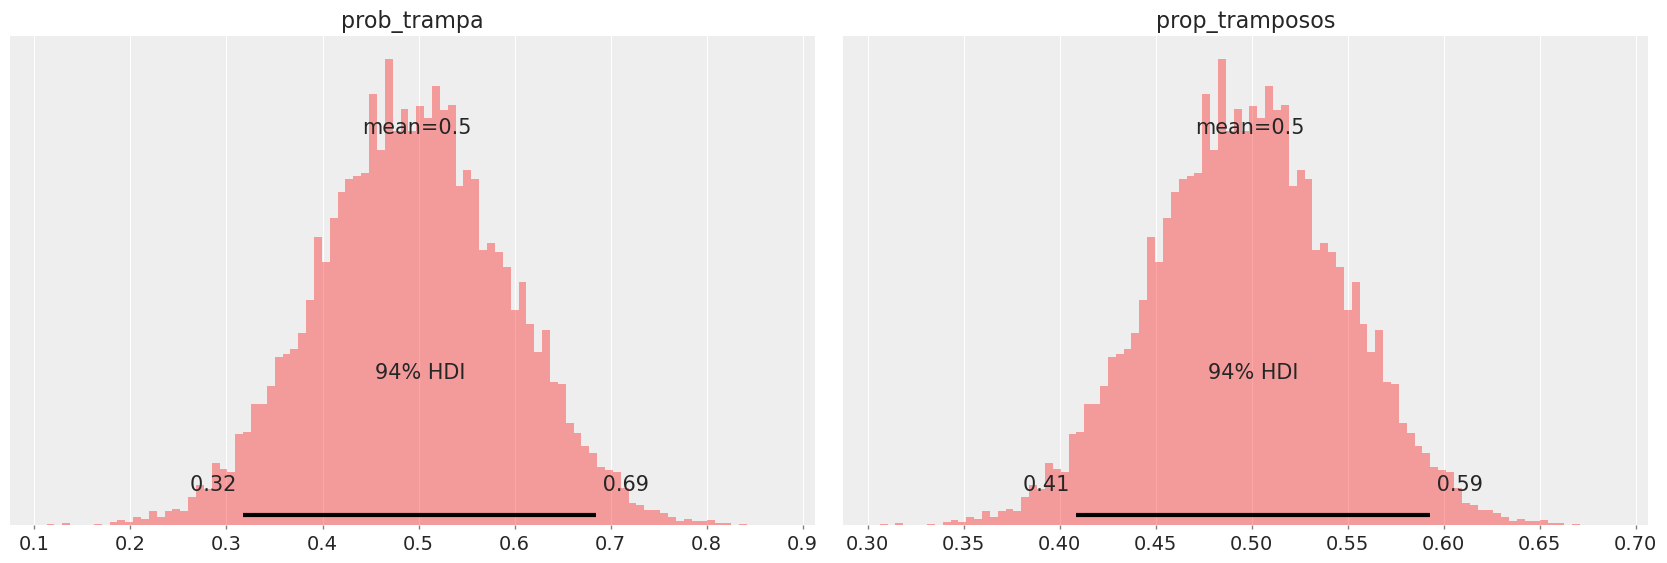

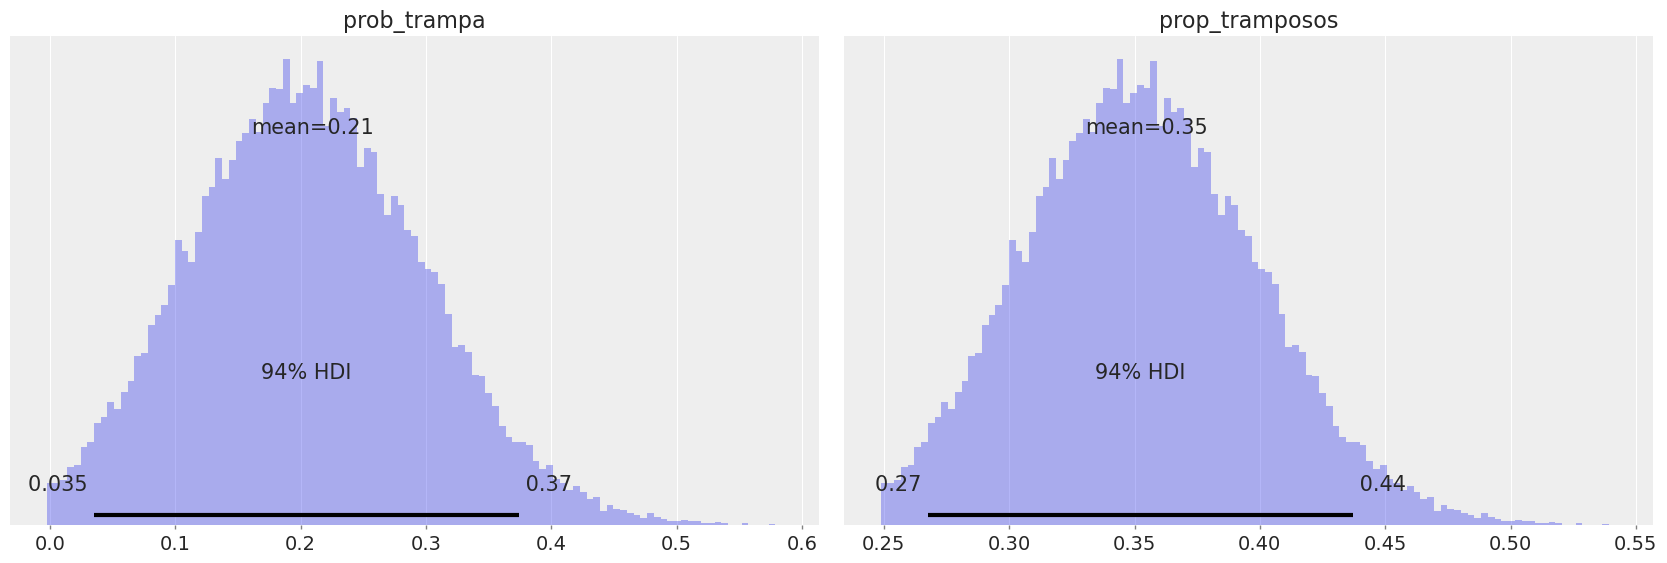

In [44]:
print('trampo=50\n',az.summary(burned_trace_50,kind='stats'))
print('trampo=35\n',az.summary(burned_trace,kind='stats'))
#Forma pro
az.plot_posterior(burned_trace_50,kind='hist',color="red")
az.plot_posterior(burned_trace,kind='hist')
print('El gráfico rojo corresponde a los valores calculados para la posterior en el caso extremo con trampo=50', 
      '\nEl gráfico azul corresponde a los valores calculados para la posterior en el caso original con trampo=35')
az.style.use("arviz-darkgrid")

**CONCLUSION**

En este se puede ver que las distribuciones de los hiperparámetros correspondientes a la probabilidad de trampa y a la proporción de tramposos, acaban por ser equivalentes al de lanzar una moneda justa. No parece haber un aumento en las desviaciones estandar en la distribución del posterior. Pareciera ser que simplemente, cuando tenemos estas respuestas en nuestros observables, no tenemos ningun tipo de información para que permita que la posterior detecte algún tipo de desviación en distribución a creer en promedio que un estuadiante puede ser honesto o deshonesto.

In [ ]:
#En general bien. Dado que la moneda es justa, el modelo encuentra que, por ejemplo, para observar 90 de 100,
#la mayoria de estudiantes de verdad deben ser tramposos, no reportan serlo porque caiga sello dos veces, 
#donde se obligan a decir que lo son.

#Ojo, no hay dos parámetros: prop_tramposos es determínistico. En alguna parte pusieron que había dos.

#En el caso 25 de 100 dicen que el posterior no se acerca a los datos originales, como si fuera negativo.
#Creo que hay una confusión, pero no se. Igual para aclarar, buscamos prop_tramp, el parámetro que nos dice cuantos de 
#verdad son tramposos. No tiene que acercarse al observable 25 de 100, depende de la moneda. 
#Con una moneda 50/50 de hecho puede ir a cero



In [46]:
e5 = ppe

#### 2. MONEDA CARGADA - model_mc
Supongamos ahora una moneda en la cual esta cargada a cara, es decir, 
* prob_cara = 0.8
* prob_sello = 0.2

Recordemos que en el experimento original los lanzamientos de la Moneda implicaban:
- CARA: 'Escribir la Verdad' 
- SELLO: Relanzamiento de la moneda. Si CARA 'Escribir la verdad' .Si SELLO entences 'no hago trampa'.

Lugo al aumentar la probabilidad de que la moneda caiga cara, lo que hacemos es simplemente tener mas respuestas acerca del valor de la honestidad de los estudiantes. (Supongamos que los tramposos nos dicen la verdad..:))

In [47]:
prob_cara_mc = 0.8
prob_sello_mc = 0.2

with pm.Model() as tramposos_mc:
    prob_trampa = pm.Uniform("prob_trampa", 0, 1) #Prior uniforme 
    prop_trampo = pm.Deterministic("prop_tramposos", prob_cara_mc*prob_trampa + prob_sello_mc*prob_cara_mc)

In [48]:
N = 100 #Número de estudiantes 
trampo = 35 #Número de reportes que dicen hacer trampa

with tramposos_mc:
    tramposos = pm.Binomial("obs", N, prop_trampo, 
                            observed=trampo)
# Ya podemos samplear
with tramposos_mc:
    step = pm.Metropolis(vars=[prob_trampa])
    trace_mc = pm.sample(40000, step=step)
    burned_trace_mc = trace_mc[15000:]

<ipython-input-48-3097883ce444>:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_mc = pm.sample(40000, step=step)
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [prob_trampa]


Sampling 4 chains for 1_000 tune and 40_000 draw iterations (4_000 + 160_000 draws total) took 43 seconds.
The number of effective samples is smaller than 25% for some parameters.


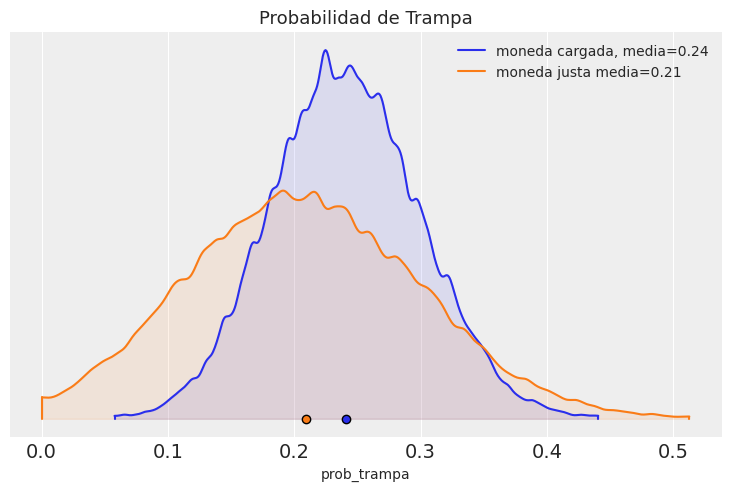

In [49]:
az.style.use("arviz-darkgrid")
az.plot_density(
    [burned_trace_mc["prob_trampa"], burned_trace["prob_trampa"]],
    data_labels=["moneda cargada, media="+ str(round(burned_trace_mc["prob_trampa"].mean(),2)),
                 "moneda justa media="+str(round(burned_trace["prob_trampa"].mean(),2))],
    shade=.1, hdi_prob=.999)
plt.xlabel('prob_trampa', fontsize = 10)
plt.legend(fontsize=10);
plt.title("Probabilidad de Trampa",fontsize=13);

Al parecer la probabilidad de encontrar estudiantes tramposos es en promedio mayor al caso orginal, dadas las respuestas que obtuvimoes en la encuenta. Parece ser que la en el caso de la moneda cargada la distrbucion del posterior adicionalemnte tiene una menor desviación estandar.

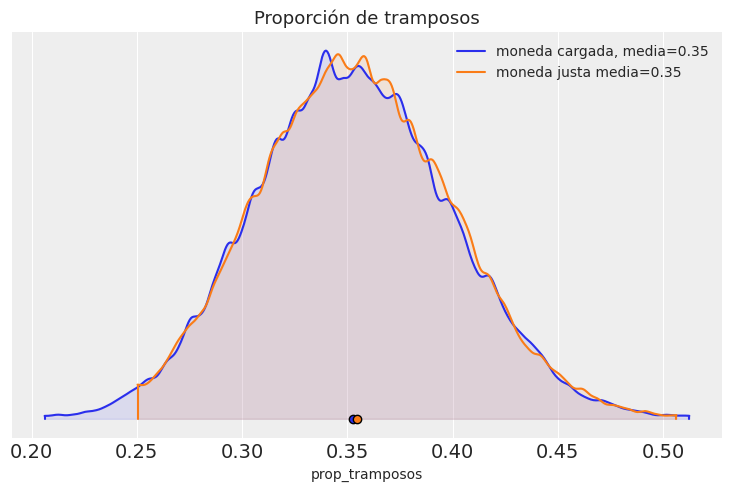

In [50]:
az.style.use("arviz-darkgrid")
az.plot_density(
    [burned_trace_mc["prop_tramposos"], burned_trace["prop_tramposos"]],
    data_labels=["moneda cargada, media="+ str(round(burned_trace_mc["prop_tramposos"].mean(),2)),
                 "moneda justa media="+str(round(burned_trace["prop_tramposos"].mean(),2))],
    shade=.1, hdi_prob=.999)
plt.legend(fontsize=10);
plt.xlabel('prop_tramposos', fontsize = 10)
plt.title("Proporción de tramposos",fontsize=13);

Por otro lado al analizar la prop de tramposos, vemos en este caso que es muy similar al caso original, aunque ligeramente mas alta, no parece haber un efecto significativo. 

In [51]:
#Forma pro
az.summary(burned_trace_mc,kind='stats')

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%
prob_trampa     0.241  0.059   0.136    0.356
prop_tramposos  0.353  0.047   0.269    0.445

In [52]:
#Forma pro
az.summary(trace,kind='stats')

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%
prob_trampa     0.209  0.091   0.037    0.375
prop_tramposos  0.355  0.045   0.268    0.437

In [53]:
e6 = 0.8*ppe

#¿Solo con p_sello<0.5? Qué tal >0.5
# Por qué creen que relativo a una moneda justa, y dado 35 de 100 observaciones, 
# prob_trampa aumenta con p_sello<0.5.
#No hay dos parámetros: prop_tramposos es determinístico.

#### 3. Nuevas distribuciones
Cambie los priors, que no sea uniforme, en el ejemplo de las trampas

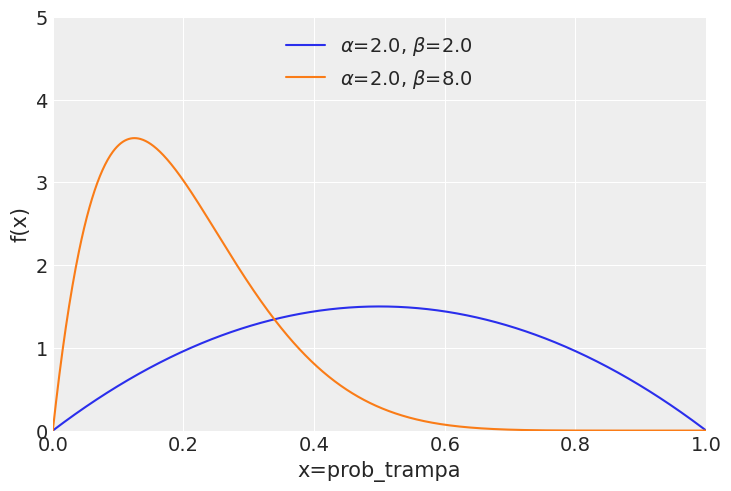

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
x = np.linspace(0.0, 1.0, 1000)
fig, ax = plt.subplots()
f = lambda a, b : st.beta.pdf(x, a, b)
plot_pdf = lambda a, b : ax.plot(x, f(a,b), label=r'$\alpha$={0}, $\beta$={1}'.format(a,b))
plot_pdf(2.0, 2.0)
plot_pdf(2.0, 8.0)
plt.legend(loc='upper center', frameon=False)
ax.set(xlim=[0,1], ylim=[0,5], xlabel='x=prob_trampa', ylabel='f(x)')
plt.show()

Recordemos que requerimos de Priors los cuales tengas un soporte en [0,1]. Luego en este caso seleccionamos dos tipos de distribuciones:
(a)-Beta($\alpha$,$\beta$)
La elección final de los parámetros para la beta es $\alpha=2.0$ y $\beta=8.0$. Note que basicamente esto quiere decir que el prior de la probabilidad de trampa esta centrado en suponer que la probabilidad de trampa es mas bien baja. Vamos a ver si tras realizar el experimento esto sigue siendo así. 

In [55]:
prob_cara = 0.5
prob_sello = 0.5
with pm.Model() as tramposos_beta:
    prob_trampa = pm.Beta("prob_trampa", 2, 8) #Prior no centrado 
    prop_trampo = pm.Deterministic("prop_tramposos", prob_cara*prob_trampa + prob_sello*prob_cara)

In [56]:
N = 100 #Número de estudiantes 
trampo = 35 #Número de reportes que dicen hacer trampa
with tramposos_beta:
    tramposos = pm.Binomial("obs", N, prop_trampo, 
                            observed=trampo)
# Ya podemos samplear
with tramposos_beta:
    step = pm.Metropolis(vars=[prob_trampa])
    trace_beta = pm.sample(10000,step=step)
    burned_trace_beta = trace_beta[1500:]

<ipython-input-56-33fd01845650>:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_beta = pm.sample(10000,step=step)
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [prob_trampa]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 22 seconds.
The number of effective samples is smaller than 25% for some parameters.


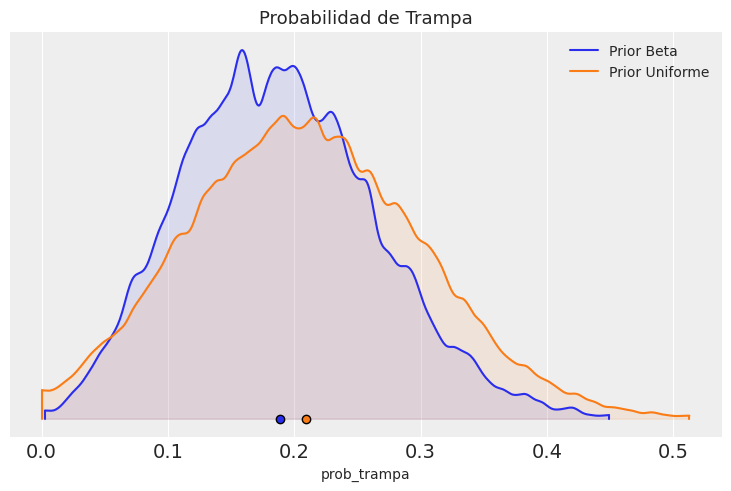

In [57]:
az.style.use("arviz-darkgrid")
az.plot_density(
    [burned_trace_beta["prob_trampa"], burned_trace["prob_trampa"]],
    data_labels=["Prior Beta","Prior Uniforme"],
    shade=.1, hdi_prob=.999)
plt.xlabel('prob_trampa', fontsize = 10)
plt.legend(fontsize=10);
plt.title("Probabilidad de Trampa",fontsize=13);

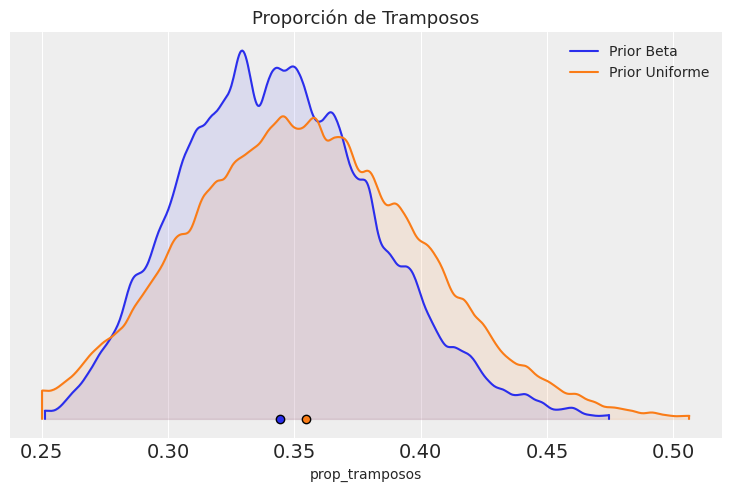

In [58]:
az.style.use("arviz-darkgrid")
az.plot_density(
    [burned_trace_beta["prop_tramposos"], burned_trace["prop_tramposos"]],
    data_labels=["Prior Beta","Prior Uniforme"],
    shade=.1, hdi_prob=.999)
plt.xlabel('prop_tramposos', fontsize = 10)
plt.legend(fontsize=10);
plt.title("Proporción de Tramposos",fontsize=13);

In [59]:
#Forma pro
print('Estadisticas del posterior en el caso de prior beta')
az.summary(burned_trace_beta,kind='stats')

Estadisticas del posterior en el caso de prior beta


C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%
prob_trampa     0.188  0.077   0.048    0.331
prop_tramposos  0.344  0.038   0.274    0.415

In [60]:
print('Estadisticas del posterior en el caso de posterior uniforme')
az.summary(burned_trace,kind='stats')

Estadisticas del posterior en el caso de posterior uniforme


C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%
prob_trampa     0.209  0.091   0.035    0.374
prop_tramposos  0.355  0.046   0.268    0.437

**CONCLUSIÓN**
Al parecer la probabilidad de trampa se ajusta un poco en la media, siendo mas baja que en el caso de la uniforme. Sin embargo, la proporcion de tramposos se acerca bastante al caso uniforme.

In [104]:
e7 = ppe

#A riesgo de repetir lo mismo: prop_tramposos no es un parámetro. 
#De hecho, prop_tramposos esperamos que se acerque a los datos 35/100, en ambos priors.

## PARTE 3: Ejercicios Comparación de Modelos
### Ejercicios (Fuente: Gelman, et al, 3era ed.)

### MODELO DE LOS OCHO COLEGIOS

In [61]:
# SAT-example data (SAT: Scholastic Aptitude Test)
# y is the estimated treatment effect
# s is the standard error of effect estimate
y = np.array([28,  8, -3,  7, -1,  1, 18, 12])
s = np.array([15, 10, 16, 11,  9, 11, 10, 18])
schools = pd.DataFrame({"Efecto":y, 'SE':s})
schools

Efecto  SE
0      28  15
1       8  10
2      -3  16
3       7  11
4      -1   9
5       1  11
6      18  10
7      12  18

In [62]:
with pm.Model() as model_colegios:
    mu = pm.Uniform('mu', 0, 30)
    tau = pm.Uniform('tau', 0, 30)    
    
    theta = pm.Normal('theta', mu=mu, sigma=tau, 
                      shape=schools.shape[0])

    y = pm.Normal('y', mu = theta, sigma = schools.loc[:,'SE'], 
                  observed = schools.loc[:,'Efecto'])
    
    # Sampleo
    trace_colegios = pm.sample(5000, tune = 1000, target_accept = 0.99)
    posterior_predictive = pm.sample_posterior_predictive(trace_colegios)

<ipython-input-62-afd6439f4bc9>:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_colegios = pm.sample(5000, tune = 1000, target_accept = 0.99)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau, mu]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 39 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9683443436264957, but should be close to 0.99. Try to increase the number of tuning steps.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9413863009676261, but should be close to 0.99. Try to increase the number of tuning steps.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9516071859359492, but should be close to 0.99. Try to increase the number of tuning steps.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>]], dtype=object)

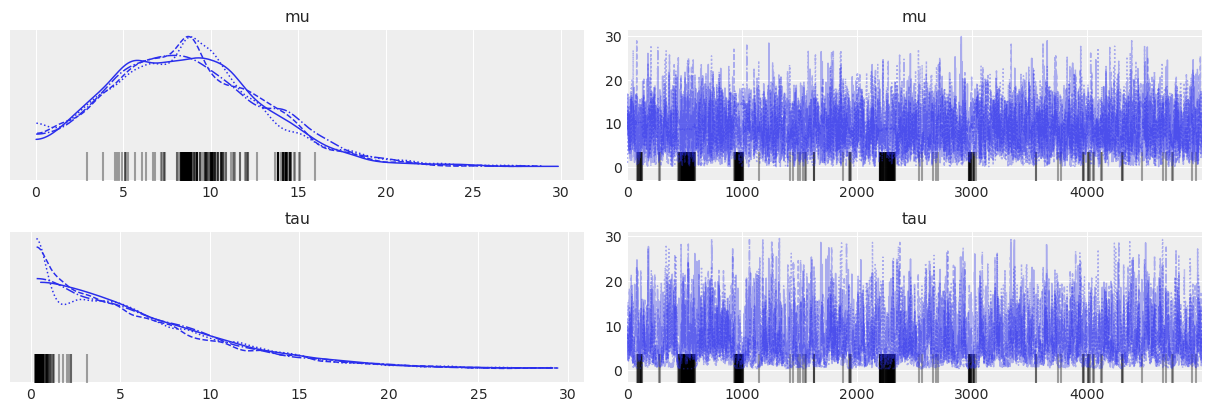

In [63]:
# Combina bien
mu_samples = trace_colegios["mu"]
tau_samples = trace_colegios["tau"]
data = az.from_pymc3(trace=trace_colegios, model=model_colegios)
az.plot_trace(data, var_names=['mu', 'tau'])

In [64]:
# Probabilidad que el programa de la escuela A 
# sea mejor que el del peor en los datos
conteo = np.sum(trace_colegios['theta'][:,0]>trace_colegios['theta'][:,2])
prob = conteo/trace_colegios['theta'].shape[0]
print("Probabilidad que el programa de la escuela A sea mejor que de la escuela C: ", np.round(prob,2))

Probabilidad que el programa de la escuela A sea mejor que de la escuela C:  0.68


**Ej_1.** Utilice las muestras del ejemplo de ocho colegios:
   
- **Para cada escuela, calcule la probabilidad que su programa es el mejor de todos**
 

In [65]:
az.summary(data)
maxx = np.amax(trace_colegios['theta'], axis = 1)
maxx.shape

name_school=['A','B','C','D','E','F','G','H']
casos_max=[]
prob_max=[]

for i in range(trace_colegios['theta'].shape[1]):
    conteo = np.sum(trace_colegios['theta'][:,i]>=maxx)
    total=trace_colegios['theta'][:,i].shape[0]
    casos_max.append(conteo)
    prob_max.append(conteo/total)

max_probability=pd.DataFrame(name_school,columns=['name_school'])
max_probability['prob_mejor_programa']=prob_max
max_probability['casos_mejor_programa']=casos_max
max_probability


name_school  prob_mejor_programa  casos_mejor_programa
0           A              0.25710                  5142
1           B              0.10105                  2021
2           C              0.08310                  1662
3           D              0.09595                  1919
4           E              0.05165                  1033
5           F              0.06905                  1381
6           G              0.19970                  3994
7           H              0.14240                  2848

In [66]:
print("Teniendo en cuenta los resultados obtenidos las escuelas A y G son las que mayor probabilidad \ntienen de tener \
el mejor programa.\
      \nPor otro lado la escuela con la escuela E pressenta la menor porbabilidad de tener el mejor programa ")
max_probability.style.background_gradient(cmap='YlGnBu') #BUENISIMO. NO CONOCIA ESTO!

Teniendo en cuenta los resultados obtenidos las escuelas A y G son las que mayor probabilidad 
tienen de tener el mejor programa.      
Por otro lado la escuela con la escuela E pressenta la menor porbabilidad de tener el mejor programa 


 - **Para cada par de escuelas j,k calcule la probabilidad que el programa j es mejor que el programa k** 
 
  En este caso vamos a suponer que la probabilidad de que una escuela sea mejor que si misma es 0.

In [67]:
#SOLUCION
conteo_jk=[]
prob_jk=[]
DF=pd.DataFrame(columns=name_school)

for j in range(trace_colegios['theta'].shape[1]):
    conteo_jk=[]
    prob_jk=[]
    for k in range(trace_colegios['theta'].shape[1]):
        c_jk=np.sum(trace_colegios['theta'][:,j]>trace_colegios['theta'][:,k])
        total=trace_colegios['theta'][:,0].shape[0]
        conteo_jk.append(c_jk)
        prob_jk.append(c_jk/total)
    DF.loc[j]=prob_jk

DF=DF.set_index([name_school],"name_school")
DF

A        B        C        D        E        F        G        H
A  0.00000  0.63685  0.67990  0.64385  0.73560  0.69480  0.52830  0.60575
B  0.36315  0.00000  0.56380  0.50990  0.63005  0.57465  0.37850  0.47660
C  0.32010  0.43620  0.00000  0.44325  0.55680  0.50245  0.32480  0.41695
D  0.35615  0.49010  0.55675  0.00000  0.61705  0.56590  0.36850  0.46500
E  0.26440  0.36995  0.44320  0.38295  0.00000  0.44575  0.26250  0.35280
F  0.30520  0.42535  0.49755  0.43410  0.55425  0.00000  0.30970  0.40395
G  0.47170  0.62150  0.67520  0.63150  0.73750  0.69030  0.00000  0.58675
H  0.39425  0.52340  0.58305  0.53500  0.64720  0.59605  0.41325  0.00000

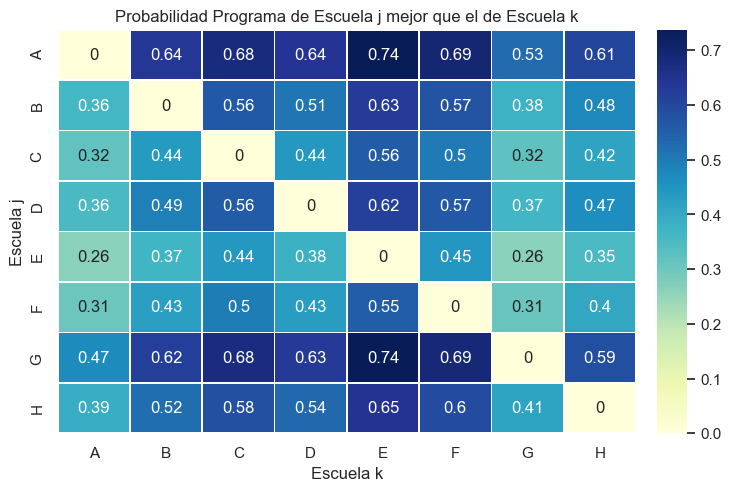

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
ax=sns.heatmap(DF,annot=True,cmap='YlGnBu', linewidths=.5)
ax.set(xlabel='Escuela k', ylabel='Escuela j',title='Probabilidad Programa de Escuela j mejor que el de Escuela k');
plt.show()

Los resultados son similares a los obtenidos en el caso del item anterior. Note que en comparacion con las otras escuelas las A y G presentan en sus filas valores mas oscuros (mas altos). Ahora bien cabe mencionar que en este caso la matriz que se muestra NO ES SIMÉTRICA. De hecho salvo la diagonal, note que 
$$P_{j,k}+P_{k,j}=1 \text{  } \forall j \neq k $$, esto tiene sentido dado que hemos definido a:
* $P_{j,k}:=\text{Probabilidad de que la escuela } j \text{sea mejor que la escuela } k $


In [69]:
e8 = ppe

# Bien pero maxx==escuela solo cuenta cuando la escuela es mayor en esa fila. 
# No cuenta si otra fila tiene valores de esa escuela que también son mayores a la fila 
# e.g. en alguna fila el aumento 5 es el mayor, y de la escuela A, 
# pero en otra fila hay un aumento de 6, también de la escuela A. Ese 6 no se conto con maxx==escuela.
# Para hacerlo había que usar np.random.choice y tomar valores aleatorios de la escuela y 
# de maxx y comparar esos vectores.

**Ej_2.** Repita 1 con $\tau$ fijo y muy grande (esto es equivalente a una estimación separada por colegio). Discuta las diferencias con los resultados del punto 1.

In [70]:
#SOLUCION
#(FORMA 1: Fijar un $\tau$ >=cota_tau y contar cuantas mustras corresponden a ser mayores que ese $\tau$
tau=20 #Fijamos un tau lo suficientemente grande. Consideramos que 20 es suficientemente grande.
cota_tau=20
bool_tau=trace_colegios['tau']>=tau
trace_colegios_tau=trace_colegios['theta'][bool_tau]

maxx_tau = np.amax(trace_colegios['theta'][bool_tau], axis = 1)
print(maxx_tau.shape)

name_school=['A','B','C','D','E','F','G','H']
casos_max=[]
prob_max=[]

for i in range(trace_colegios['theta'].shape[1]):
    conteo = np.sum(trace_colegios['theta'][bool_tau,i]>=maxx_tau)
    total=trace_colegios['theta'][bool_tau,i].shape[0]
    casos_max.append(conteo)
    prob_max.append(conteo/total)

max_probability=pd.DataFrame(name_school,columns=['name_school'])
max_probability['prob_mejor_programa']=prob_max
max_probability['casos_mejor_programa']=casos_max
max_probability['total_muestras']=total
max_probability

(400,)


name_school  prob_mejor_programa  casos_mejor_programa  total_muestras
0           A               0.5450                   218             400
1           B               0.0500                    20             400
2           C               0.0575                    23             400
3           D               0.0625                    25             400
4           E               0.0025                     1             400
5           F               0.0125                     5             400
6           G               0.1400                    56             400
7           H               0.1300                    52             400

A diferencia del primer caso simplemente estamos reduciendo las muestras a los casos en los que tau era muy alto, mayor o igual a 20, por esto vemos qie en el caso de las muestras estan disminuyen, pasando de ser de tan solo 203, que son las que cumplen con nuestra condición de $tau$. La escuela A parece seguir siendo la que mayor probabilidad tiene de tener el mejor programa

In [71]:
#SOLUCION
conteo_jk_tau=[]
prob_jk_tau=[]
DF_tau=pd.DataFrame(columns=name_school)

for j in range(trace_colegios['theta'].shape[1]):
    conteo_jk_tau=[]
    prob_jk_tau=[]
    for k in range(trace_colegios['theta'].shape[1]):
        ctau_jk=np.sum(trace_colegios['theta'][bool_tau,j]>trace_colegios['theta'][bool_tau,k])
        total=trace_colegios['theta'][bool_tau,0].shape[0]
        conteo_jk_tau.append(ctau_jk)
        prob_jk_tau.append(ctau_jk/total)
    DF_tau.loc[j]=prob_jk_tau

DF_tau=DF_tau.set_index([name_school],"name_school")
DF_tau

A       B       C       D       E       F       G       H
A  0.0000  0.8425  0.8750  0.8350  0.9350  0.9200  0.7200  0.7750
B  0.1575  0.0000  0.6350  0.5425  0.7450  0.6325  0.2400  0.4575
C  0.1250  0.3650  0.0000  0.3550  0.5375  0.4525  0.1875  0.3100
D  0.1650  0.4575  0.6450  0.0000  0.6950  0.6075  0.2750  0.4325
E  0.0650  0.2550  0.4625  0.3050  0.0000  0.3850  0.0900  0.2375
F  0.0800  0.3675  0.5475  0.3925  0.6150  0.0000  0.1600  0.3150
G  0.2800  0.7600  0.8125  0.7250  0.9100  0.8400  0.0000  0.6275
H  0.2250  0.5425  0.6900  0.5675  0.7625  0.6850  0.3725  0.0000

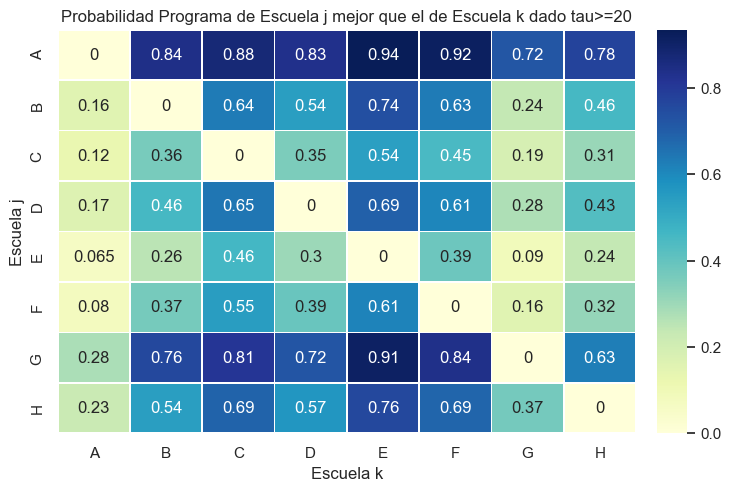

In [72]:
sns.set()
ax=sns.heatmap(DF_tau,annot=True,cmap='YlGnBu', linewidths=.5)
ax.set(xlabel='Escuela k', ylabel='Escuela j'
       ,title='Probabilidad Programa de Escuela j mejor que el de Escuela k dado tau>='+str(cota_tau));
plt.show()

Al igual que en el caso anterior se evidencia que los programas de las escuelas A y G tienen una mayor probabilidad de ser mejores que los de las demás escuelas. De nuevo se cumple que la matriz no se es simétrica.
Recuerde que $\tau$ correspondia a la desviación del hiperprior normal que se tenia sobre el efecto medio del programa.

In [73]:
e9 = ppe
# En general, parece ser que estimar el efecto de forma independiente cambia las probabilidades. 
# Para la escuela A, por ejemplo, es claro que aumenta la probabilidad de ser la mejor.
# Habría que hacer una comparación de modelos, por ejemplo con WAIC o Bayes factors,
# para determinar si el modelo jerárquico o independiente es mejor.

### MODELO DE TUMORES EN RATAS
Descripción: determinar $\theta$, la probabilidad de tumor en ratas de laboratorio (F344) que no reciben medicamento experimental.

Datos: 1 experimento que se acaba de hacer. 70 grupos de ratas testeadas antes. 

Este ejemplo se va a modelar de forma jerárquica y con priors basados en data anterior. 

71 experimentos con j grupos de ratas. 

$\theta_j$ depende de `hiperparámetros` $\alpha, \beta$: 

Hiperparámetros reflejan condiciones del grupo, experimento, o día. 

Las distribuciones para $y_j$ & $\theta_j$:
* Beta esta entre [0,1], perfecto para proporciones.
* Binomial, es discreta para conteos.

La distribución $p(\alpha,\beta)$:
* Uniforme entre $$\left[\frac{\alpha}{\alpha+\beta}, (\alpha+\beta)^{-1/2} \right]$$
* El 1er extremo es el promedio de $\theta_j$
* El 2do extremo depende del denominador del promedio de $\theta_j$: $\alpha + \beta$
* $(\alpha + \beta)^{-5/2}$, es luego de volver a las variables originales (ver Gelman, et al, 2013, Hierarchical Models)

In [74]:
#Data
rats = pd.DataFrame(
    np.loadtxt("data/5_CB/rats.asc", skiprows=1), 
    columns = ['y','n']
)
rats.head(10) #y: with tumor; n: total rats

y     n
0  0.0  20.0
1  0.0  20.0
2  0.0  20.0
3  0.0  20.0
4  0.0  20.0
5  0.0  20.0
6  0.0  20.0
7  0.0  19.0
8  0.0  19.0
9  0.0  19.0

In [75]:
# p(alpha,beta) en log (el algoritmo trabaja con logs)
def logp_ab(a,b):
    return tt.log(tt.pow(a+b, -5/2))

with pm.Model() as model_rats:  
    a = pm.Uniform('alpha', 0.05, 100)
    b = pm.Uniform('beta', 0.05, 100)    
    pm.Potential('p(a, b)', logp_ab(a,b)) 
    #Pueden remover el Potential (es simila a increase_log de stan)
    #(pero ver Gelman, 2013, Ch 5, ed 3)
    #El algoritmo no falla si limitamos alpha y beta.
    
    theta = pm.Beta('theta', alpha=a, beta=b, 
                    shape=rats.shape[0])

    y = pm.Binomial('y', p=theta, n=rats.loc[:,'n'], 
                    observed=rats.loc[:,'y'])
    
    # Sampleo
    trace_rats = pm.sample(5000, target_accept=.95)
    #the step size in PyMC3 is tuned automatically during warm up, 
    #but we can coerce smaller step sizes by tweaking the configuration 
    #of PyMC3’s adaptation routine. In particular, we can increase the 
    #target_accept parameter from its default value of 0.8 closer 
    #to its maximum value of 1
    ##posterior_predictive = pm.sample_posterior_predictive(trace)


<ipython-input-75-9f13c861044a>:20: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_rats = pm.sample(5000, target_accept=.95)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, beta, alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 36 seconds.
The number of effective samples is smaller than 25% for some parameters.


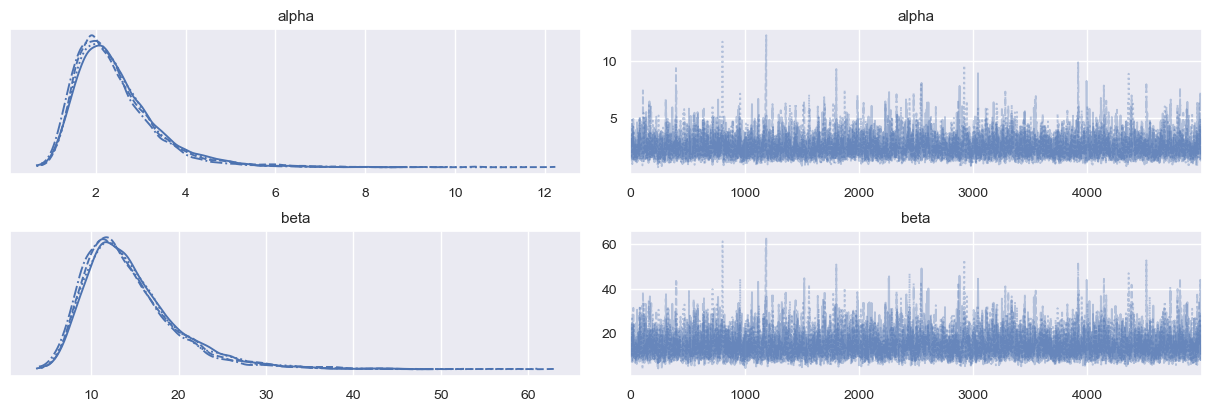

In [76]:
# Combina bien
beta_samples = trace_rats["beta"]
alpha_samples = trace_rats["alpha"]
data = az.from_pymc3(trace=trace_rats, model=model_rats)
az.plot_trace(data, var_names=['alpha', 'beta']);

Text(0.5, 1.0, 'Posterior marginal de alpha y beta')

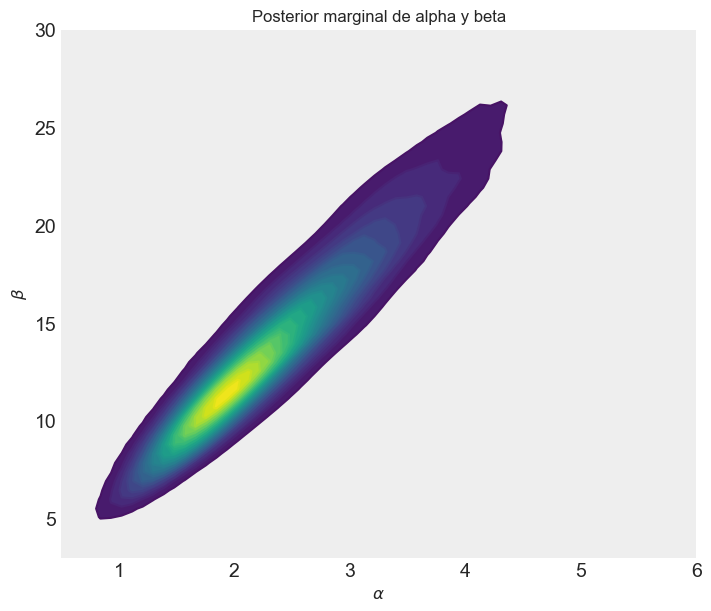

In [77]:
az.style.use("arviz-darkgrid")
fig, ax = plt.subplots(figsize=(7, 6))
az.plot_kde(values=alpha_samples, values2=beta_samples, 
            ax=ax, contour=True, 
            contour_kwargs={'colors': None, "levels":20,  'cmap': 'viridis'},
            contourf_kwargs={"levels":20})
ax.set_xlim([0.5,6]);
ax.set_ylim([3,30]);
plt.xlabel(r'$\alpha$', fontsize = 12)
plt.ylabel(r'$\beta$', fontsize = 12)
plt.title('Posterior marginal de alpha y beta', fontsize = 12)

**3.** Utilice la data de las ratas pero ahora trabaje/transforme a la escala log-odds (nota: logit(0) es menos infinito; cambie los ceros por valores cercanos e.g. 1e-200; o alternativamente siga con la data de conteos pero use inverse logit de theta cuando este en el modelo de pymc). \
Tome muestras de $\theta_j \sim Normal(\mu, \tau)$, donde $\tau$ es la desviación estandar ($\theta_j$ está en escala logit). Interprete los resultados en esa escala. Tip: puede usar likelihood normal o binomial. Si usa binomial, use inverse logit de theta_j para p.

In [ ]:
#SOLUCION
#Data
rats = pd.DataFrame(
    np.loadtxt("data/5_CB/rats.asc", skiprows=1), 
    columns = ['y','n']
)
rats.head(10)

- Comenzamos hallando en este caso $p_{i}=y_{i}/n_{i}$, que es la probabilidad de que una de las ratas tenga un tumor (proporción de ratas en el experimento $j$ experimento que presentaron un tumor). Este valor lo usaremos posteriormente como la probabilidad del logit.

In [78]:
rats['p']=rats['y']/rats['n']
rats

y     n         p
0    0.0  20.0  0.000000
1    0.0  20.0  0.000000
2    0.0  20.0  0.000000
3    0.0  20.0  0.000000
4    0.0  20.0  0.000000
..   ...   ...       ...
66  16.0  52.0  0.307692
67  15.0  46.0  0.326087
68  15.0  47.0  0.319149
69   9.0  24.0  0.375000
70   4.0  14.0  0.285714

[71 rows x 3 columns]

- Transformamos ahora los datos en escala logit. Para esto recordemos que:
$$logit(p_i)=ln \biggl(\frac{p_{i}}{1-p_{i}}\biggl)=ln \biggl(\frac{y_{i}}{n_{i}-y_{i}}\biggl)$$

In [79]:
rats['logit_p']= np.where(rats['p']== 0.0, np.log(1e-200/(1-1e-200)), np.log(rats['p']/(1-rats['p'])))
rats

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


y     n         p     logit_p
0    0.0  20.0  0.000000 -460.517019
1    0.0  20.0  0.000000 -460.517019
2    0.0  20.0  0.000000 -460.517019
3    0.0  20.0  0.000000 -460.517019
4    0.0  20.0  0.000000 -460.517019
..   ...   ...       ...         ...
66  16.0  52.0  0.307692   -0.810930
67  15.0  46.0  0.326087   -0.725937
68  15.0  47.0  0.319149   -0.757686
69   9.0  24.0  0.375000   -0.510826
70   4.0  14.0  0.285714   -0.916291

[71 rows x 4 columns]

Ahora podemos pensar en los $\theta's$ en una escala logit $[-\infty , +-\infty ]$. Pues hemos transformado esta variable a la escala logit.Recordemos anteriormente que el prior estaba dado por $\theta_j \sim Beta(\alpha, \beta)$. Sin embargo, ahora estamos en una transformación logit, luego el nuevo prior será $\theta_j \sim Normal(\mu,\tau)$ 

El likelihood es ahora normal. Adicionalmente nustros observables estan en la escala logit.

**SIMULACIONES EN ESCALA LOGIT**

In [80]:
with pm.Model() as rats_logit1:  
    #Hyperprior Definition: thetha hyperpriors-para cada experimentro (grupo de ratas j)
    mu_l=pm.TruncatedNormal('mu', mu=0, sigma=2, lower=-10, upper=10) #SANTIAGO: Por qué centrado en 0 y truncado -10,10 ... mu puede ser mucho más bajo
    tau = pm.Uniform('tau', 0, 3) 
    
    #Prior de los thethas de cada grupo de (ratas)
    theta=pm.Normal('theta',mu_la,tau,shape=rats.shape[0]) #Distribucion del promedio de ratas, pero en escala logit
    #    pm.math.invlogit()
    theta_inv=pm.Deterministic('theta_inv',pm.math.invlogit(theta)) #recobrar theta para probabilidades
    
    #Likeihood
    logit_p = pm.Normal('logit_p', mu=theta, sigma=rats['logit_p'].std(), observed=rats.loc[:,'logit_p'])
    
    # Sampleo
    trace_rats_logit1 = pm.sample(5000, cores=4,target_accept=.99)

<ipython-input-80-f17fc773793e>:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_rats_logit1 = pm.sample(5000, cores=4,target_accept=.99)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau, mu]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 311 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9705893515987231, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9713744751058685, but should be close to 0.99. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


Verificamos si combina bien.

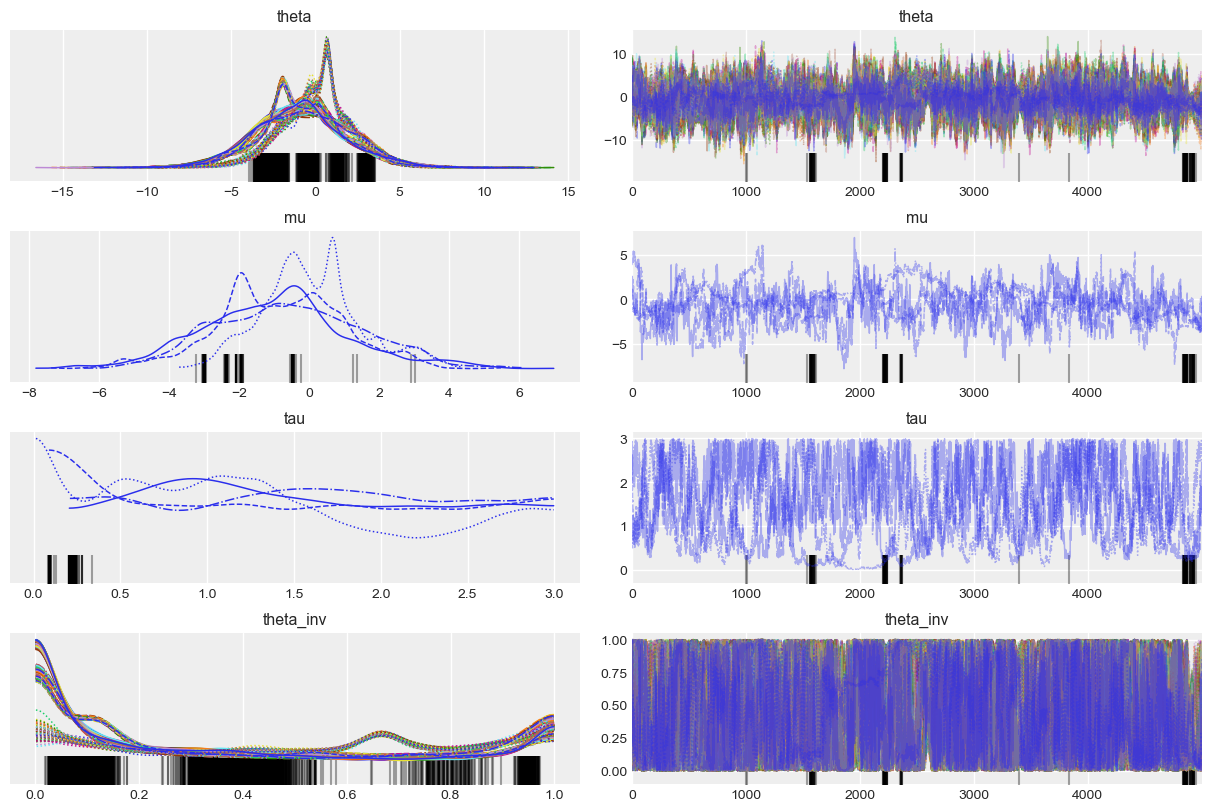

In [81]:
data = az.from_pymc3(trace=trace_rats_logit1, model=rats_logit1)
az.plot_trace(data);

No parece combinar muy bien. De hecho se evidencian algunos problemas de convergencia. Sin embargo, se explora mas adelante la posibilidad de trabajar conteos a ver si mejoran los resultados.

Hacemos el plot de los resultados. En este caso note que ya hemos obtenido los valores de forma similar al ejercicio original,Note que los valores de los parametros de los hiperpriors están en escala logit

C:\ProgramData\Anaconda3\lib\site-packages\arviz\plots\jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:xlabel='mu', ylabel='tau'>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


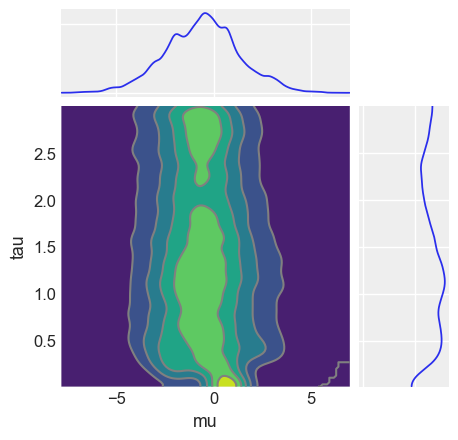

In [82]:
az.plot_joint(trace_rats_logit1,
            var_names=['mu','tau'],
            kind='kde',
            figsize=(5, 5))

**SIMULACIONES TRANSFORMADAS A ESCALA CONTEOS**

In [83]:
with pm.Model() as rats_logit:  
    #Hyperprior Definition: thetha hyperpriors-para cada experimentro (grupo de ratas j)
    mu = pm.TruncatedNormal('mu', mu=0, sigma=2, lower=-10, upper=10)
    tau = pm.Uniform('tau', 0, 10)
    
    #Prior de los thethas de cada grupo de (ratas)
    theta_logit=pm.Normal('theta',mu,tau,shape=rats.shape[0]) #Distribucion del promedio de ratas, pero en escala logit
    #Recordemos que en este caso theta_logit debe ser gransformado para recuperar la probabilidad pm.math.invlogit()
    theta=pm.Deterministic('theta_inv',pm.math.invlogit(theta_logit))
    
    #Likeihood
    y = pm.Binomial('y', p=theta, n=rats.loc[:,'n'],observed=rats.loc[:,'y'])
    # Sampleo
    trace_rats_logit = pm.sample(5000, cores=4,target_accept=.99)

<ipython-input-83-9a3896e4f3b6>:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_rats_logit = pm.sample(5000, cores=4,target_accept=.99)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau, mu]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 32 seconds.
The number of effective samples is smaller than 25% for some parameters.


Verificamos si combina bien.

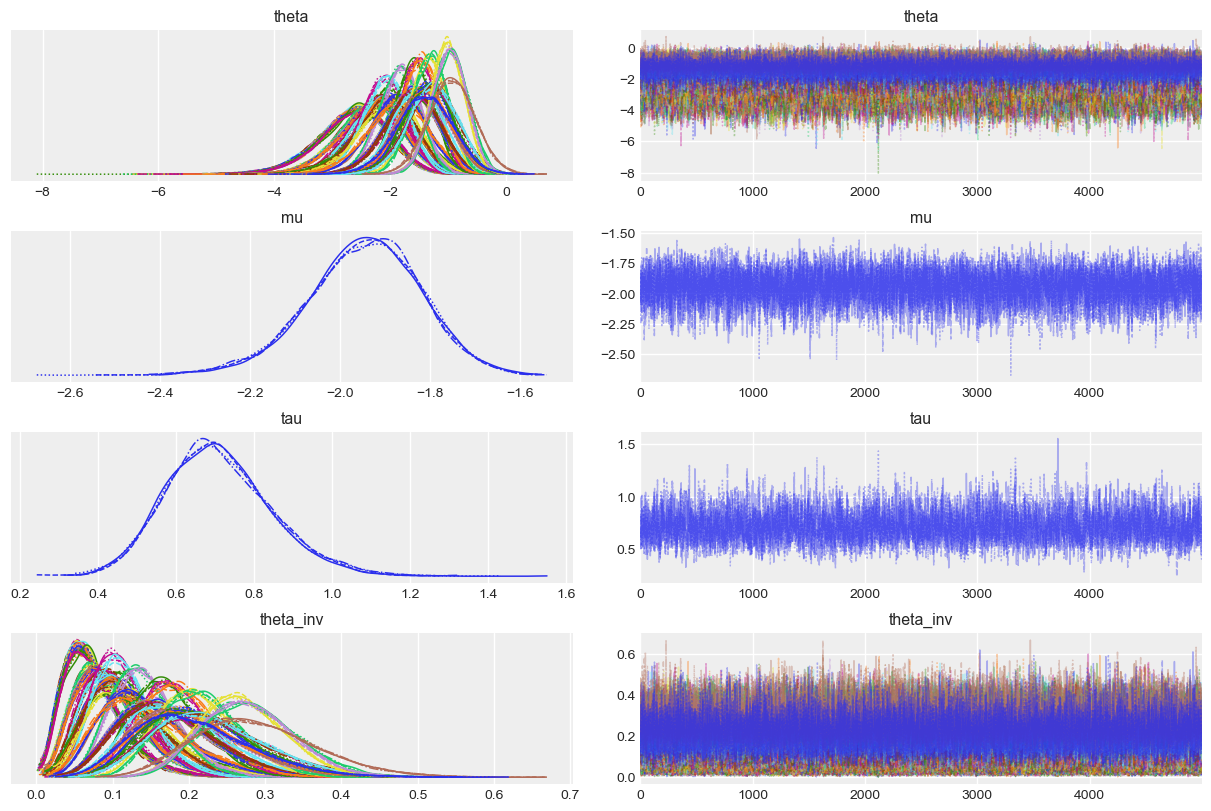

In [84]:
data = az.from_pymc3(trace=trace_rats_logit, model=rats_logit)
az.plot_trace(data);

Hacemos el plot de los resultados. En este caso note que ya hemos obtenido los valores de forma similar al ejercicio original, es decir, en las mismas unidades.

C:\ProgramData\Anaconda3\lib\site-packages\arviz\plots\jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:xlabel='mu', ylabel='tau'>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


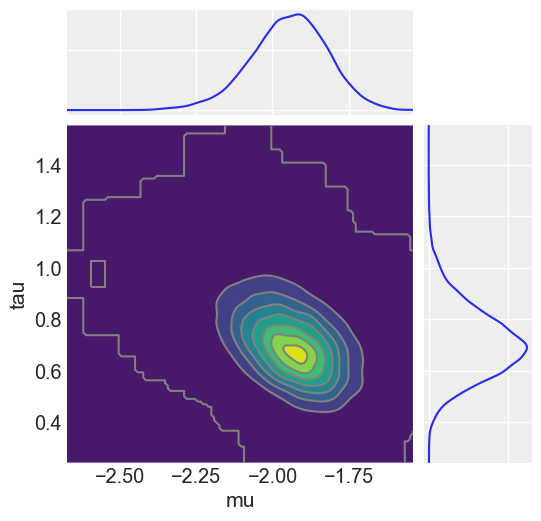

In [85]:
az.plot_joint(trace_rats_logit,
            var_names=['mu','tau'],
            kind='kde',
            figsize=(6, 6))

Text(0.5, 1.0, 'Posterior marginal de mu y tau')

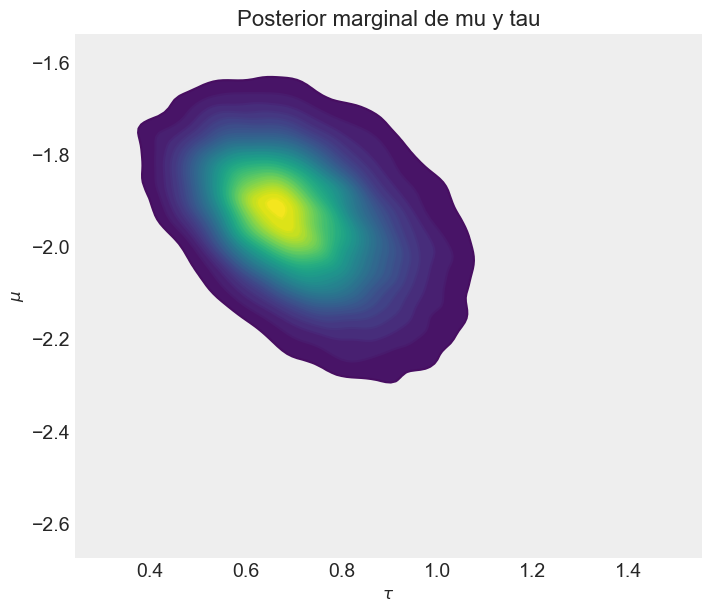

In [86]:
fig, ax = plt.subplots(figsize=(7, 6))
az.plot_kde(values=trace_rats_logit['tau'], values2=trace_rats_logit['mu'], 
            ax=ax, contour=True, 
            contour_kwargs={'colors': None, "levels":30,  'cmap': 'viridis'},
            contourf_kwargs={"levels":30})
plt.xlabel(r'$\tau$', fontsize = 12)
plt.ylabel(r'$\mu$', fontsize = 12)
plt.title('Posterior marginal de mu y tau', fontsize = 16)

Text(0, 0.5, '95% HDI de $\\theta_i$')

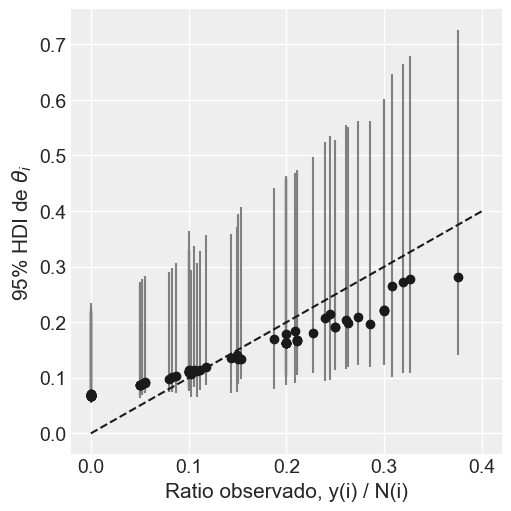

In [87]:
median_theta = np.median(trace_rats_logit['theta_inv'], axis=0)
hdi_ = az.hdi(trace_rats_logit['theta_inv'][None,:], hdi_prob=.95)

plt.figure(figsize=(5, 5))
plt.errorbar(rats.loc[:, 'y'] / rats.loc[:, 'n'], median_theta, fmt='o',
             yerr=[hdi_[:, 0], hdi_[:, 1]], ecolor='gray', 
             markerfacecolor='k', mec='k')
plt.plot(np.linspace(0, .4, 10), np.linspace(0, .4, 10), 'k--')
plt.xlabel('Ratio observado, y(i) / N(i)', fontsize = 15)
plt.ylabel(r'95% HDI de $\theta_i$', fontsize = 15)

Paerce que combina bien.

In [88]:
e10 = ppe

#PARA EL MODELO QUE TIENE DIFICULTADES, REVISEN EL R HAT.
#EL PROBLEMA DE CONVERGENCIA PUEDE SER POR QUE TRUNCARON MU MUY BAJO Y TAU TAMBIÉN ES MÁXIMO 3. 
#LA COSA ES QUE LA ESCALA DE MU ES LOGIT Y LA BASE DE DATOS TIENE VALORES LOGIT BIEN BAJOS, E.G. -460.517019
#AL ALGORITMO LE ESTÁ COSTANDO TRABAJO EXPLICAR ALGUNOS DATOS Y CREO QUE ES POR ESA TRUNCADA.

### UN MODELO SIMILAR AL DE LAS RATAS - Proporción de Bicis

4. En los alrededores del campus de una universidad se hizo un conteo de tráfico de bicicletas y otros vehiculos. Sesenta bloques se seleccionaron y se observaron por una hora. Los bloques se escogieron acorde a su nivel de actividad (bien ocupado, ocupación normal, y residencial) y si tenían bicirutas o no. La data la puede encontrar en transit.csv. Centrese en las 10 primeras filas. Haga lo siguiente:

* Un modelo jerárquico como el del tumor de las ratas. Ahora n es el total de vehiculos (bicis+otros) y la variable de interés es la proporción de bicis. Es decir, infiera $\theta_j$, la proporción latente de bicicletas de cada bloque, con la data disponible (solo las 10 primeras filas).
* Compare la posterior del parámetro $\theta_j$  con las proporciones que hay en la data en cada bloque (# de bicicletas / # vehiculos incluyendo bicicletas). Comente cómo difieren (o no) la proporciones de la data y la inferencia de la posterior del parámetro $\theta_j$
    * Calcule el intervalo posterior al 95% de la proporción de tráfico de bicicletas en todos los bloques.  Agrupe todos los $\theta_j$, queremos un intervalo general.
    * Corra el modelo ahora con los siguientes priors y likelihood:
        * Likelihood para el conteo de bicicletas es una $Poisson(\theta_j)$. Ahora $\theta_j$ es el número promedio de bicis por hora.
        * Prior $Gamma(\alpha,\beta)$ para $\theta_j$. Asigne uniformes para los hiperparámetros $\alpha$ y $\beta$
        * Haga un gráfica con los hiperparámetros (eje x: $\alpha$, eje y: $\beta$)
    
    

In [89]:
#SOLUCION
#Data
bicis = pd.read_csv("data/5_CB/transit.csv",nrows=10)
bicis

category bike_friendly  n_bikes  n_other  block
0  Residential           Yes     16.0     58.0      0
1  Residential           Yes      9.0     90.0      1
2  Residential           Yes     10.0     48.0      2
3  Residential           Yes     13.0     57.0      3
4  Residential           Yes     19.0    103.0      4
5  Residential           Yes     20.0     57.0      5
6  Residential           Yes     18.0     86.0      6
7  Residential           Yes     17.0    112.0      7
8  Residential           Yes     35.0    273.0      8
9  Residential           Yes     55.0     64.0      9

Note que en este caso los datos los tomamos sobre solamente los valores de los bloques residenciales, por tanto vamos a trabajar solamente con este bloque. Pues en nuestros observables NO tenemos inforacion que nos permita definir un likelihood sobre los otros bloques. En este caso tenemos simplemente datos para un total de 10 bloques.
En contraste con el caso de las ratas donde teniamos 71 jerarquias (para cada experimento), aquí serían simplemente 10, donde cada jerarquía corresponde a un bloque.

(PASO 1)-Completamos con los valores de $n=n_{bikes}+n_{other}$ y $p=\frac{n_{bikes}}{n}$

In [90]:
bicis['n']=bicis['n_bikes']+bicis['n_other']
bicis['p']=bicis['n_bikes']/(bicis['n_bikes']+bicis['n_other'])
bicis

category bike_friendly  n_bikes  n_other  block      n         p
0  Residential           Yes     16.0     58.0      0   74.0  0.216216
1  Residential           Yes      9.0     90.0      1   99.0  0.090909
2  Residential           Yes     10.0     48.0      2   58.0  0.172414
3  Residential           Yes     13.0     57.0      3   70.0  0.185714
4  Residential           Yes     19.0    103.0      4  122.0  0.155738
5  Residential           Yes     20.0     57.0      5   77.0  0.259740
6  Residential           Yes     18.0     86.0      6  104.0  0.173077
7  Residential           Yes     17.0    112.0      7  129.0  0.131783
8  Residential           Yes     35.0    273.0      8  308.0  0.113636
9  Residential           Yes     55.0     64.0      9  119.0  0.462185

(PASO 2)-Corremos el modelo con las distribuciones definidas
* Compare la posterior del parámetro $\theta_j$  con las proporciones que hay en la data en cada bloque (# de bicicletas / # vehiculos incluyendo bicicletas). Comente cómo difieren (o no) la proporciones de la data y la inferencia de la posterior del parámetro $\theta_j$
    * Calcule el intervalo posterior al 95% de la proporción de tráfico de bicicletas en todos los bloques.  Agrupe todos los $\theta_j$, queremos un intervalo general.

In [91]:
with pm.Model() as model_bicis:  
    a = pm.Uniform('alpha', 0.05, 100)
    b = pm.Uniform('beta', 0.05, 100)    
    
    theta = pm.Beta('theta', alpha=a, beta=b,shape=bicis.shape[0])

    y = pm.Binomial('y', p=theta, n=bicis.loc[:,'n'],observed=bicis.loc[:,'n_bikes'])
    
    # Sampleo
    trace_bicis = pm.sample(10000,cores=4, target_accept=.95)
    #the step size in PyMC3 is tuned automatically during warm up, 
    #but we can coerce smaller step sizes by tweaking the configuration 
    #of PyMC3’s adaptation routine. In particular, we can increase the 
    #target_accept parameter from its default value of 0.8 closer 
    #to its maximum value of 1
    ##posterior_predictive = pm.sample_posterior_predictive(trace)

<ipython-input-91-95cba559e366>:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_bicis = pm.sample(10000,cores=4, target_accept=.95)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, beta, alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 38 seconds.


Al igual que en el ejemplo de las ratas, verificamos que combina bien

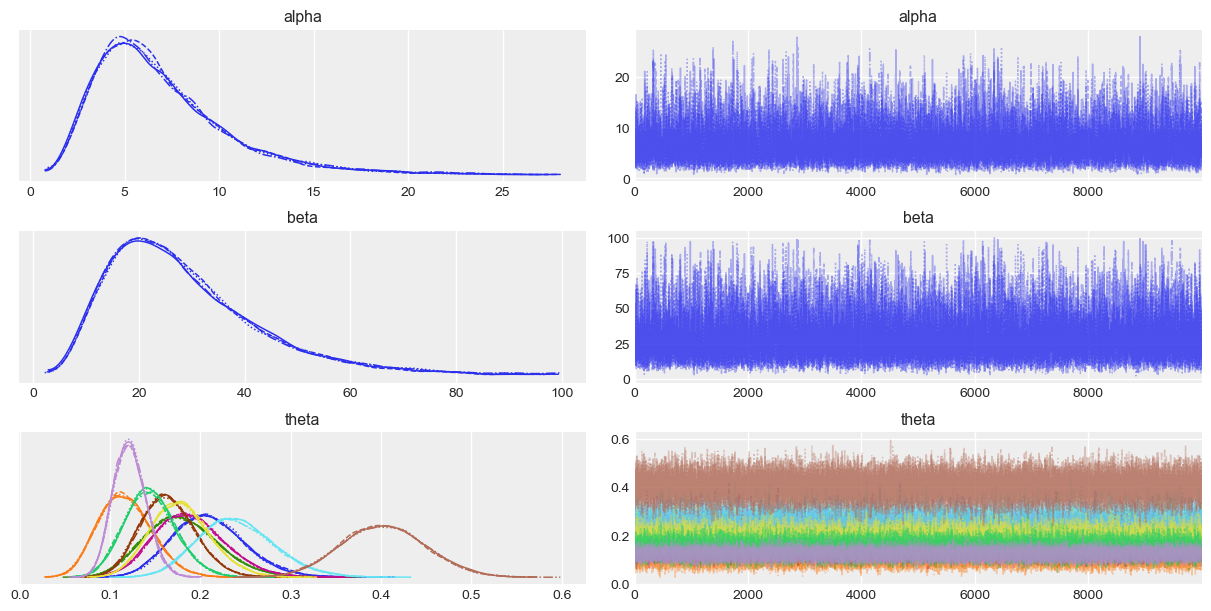

In [92]:
data = az.from_pymc3(trace=trace_bicis, model=model_bicis)
az.plot_trace(data);

El modelo converge y combina bien. Procedemos a comparar con los valores oservados con el intervalo del 95% de la posterior, agrupada usando la mediana

Text(0, 0.5, '95% HDI de $\\theta_i$')

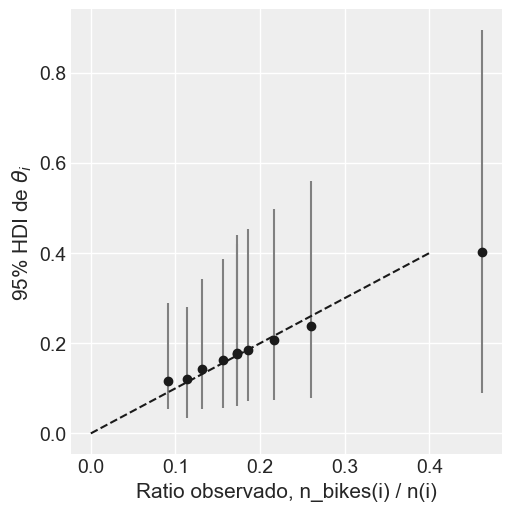

In [93]:
median_theta = np.median(trace_bicis['theta'], axis=0)
hdi_ = az.hdi(trace_bicis['theta'][None,:], hdi_prob=.95)

plt.figure(figsize=(5, 5))
plt.errorbar(bicis.loc[:, 'n_bikes'] / bicis.loc[:, 'n'], median_theta, fmt='o',
             yerr=[hdi_[:, 0], hdi_[:, 1]], ecolor='gray', 
             markerfacecolor='k', mec='k')
plt.plot(np.linspace(0, .4, 10), np.linspace(0, .4, 10), 'k--')
plt.xlabel('Ratio observado, n_bikes(i) / n(i)', fontsize = 15)
plt.ylabel(r'95% HDI de $\theta_i$', fontsize = 15)

Se evidencia que el modelo combina bien los valores de la posterior con los observados

In [94]:
#Extiendan la línea punteada de identidad hasta el ultimo punto a la derecha.
#Yo no usaría combina bien pues eso es de la traza.
#Depronto mejor decir se relaciona ... o refleja bien.

(PASO 3)-Corremos de nuevo el modelo ahora con las nuevas condiciones.
- Likelihood para el conteo de bicicletas es una $Poisson(\theta_j)$. Ahora $\theta_j$ es el número promedio de bicis por hora.
- Prior $Gamma(\alpha,\beta)$ para $\theta_j$. Asigne uniformes para los hiperparámetros $\alpha$ y $\beta$
- Haga un gráfica con los hiperparámetros (eje x: $\alpha$, eje y: $\beta$)
    
   

In [95]:
with pm.Model() as model_bicis2:  
    a = pm.Uniform('alpha', 0.05, 100)
    b = pm.Uniform('beta', 0.05, 100)    
    
    theta = pm.Gamma('theta', alpha=a, beta=b,shape=bicis.shape[0])

    y = pm.Poisson('y', mu=theta,observed=bicis.loc[:,'n_bikes'])
    
    # Sampleo
    trace_bicis2 = pm.sample(10000,cores=4, target_accept=.95)
    #the step size in PyMC3 is tuned automatically during warm up, 
    #but we can coerce smaller step sizes by tweaking the configuration 
    #of PyMC3’s adaptation routine. In particular, we can increase the 
    #target_accept parameter from its default value of 0.8 closer 
    #to its maximum value of 1
    ##posterior_predictive = pm.sample_posterior_predictive(trace)

<ipython-input-95-db07576eab84>:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_bicis2 = pm.sample(10000,cores=4, target_accept=.95)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, beta, alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 40 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


Verificamos que combina bien:

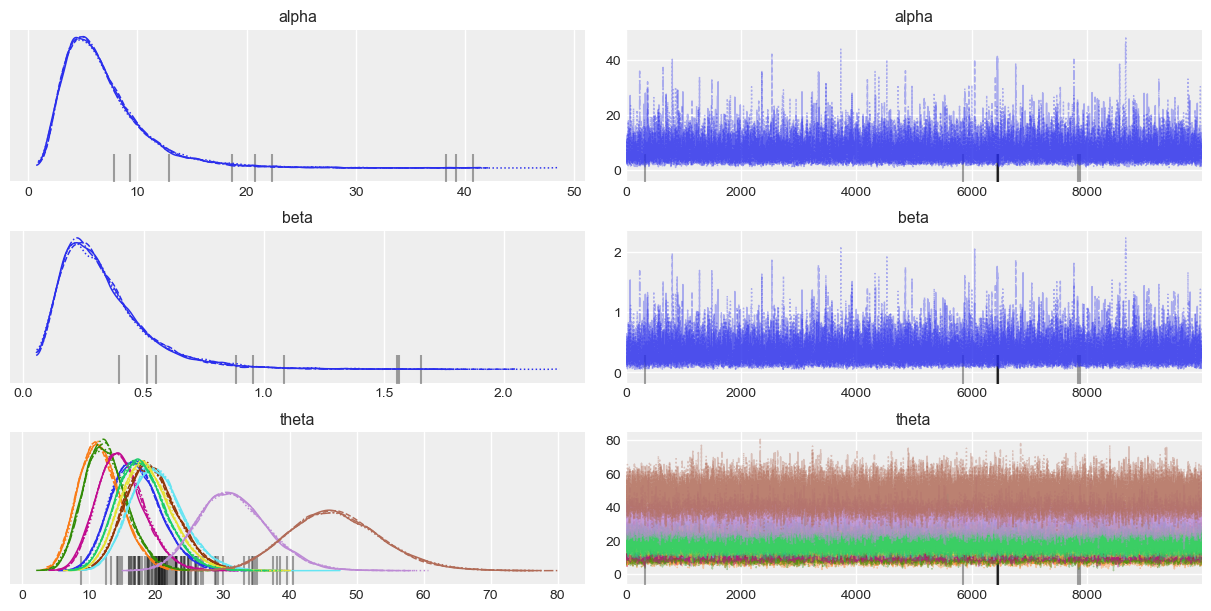

In [96]:
data = az.from_pymc3(trace=trace_bicis2, model=model_bicis2)
az.plot_trace(data);

Procedemos a hacer el plot de los hyperparametros alpha y beta.

Text(0.5, 1.0, 'Posterior marginal de alpha y beta')

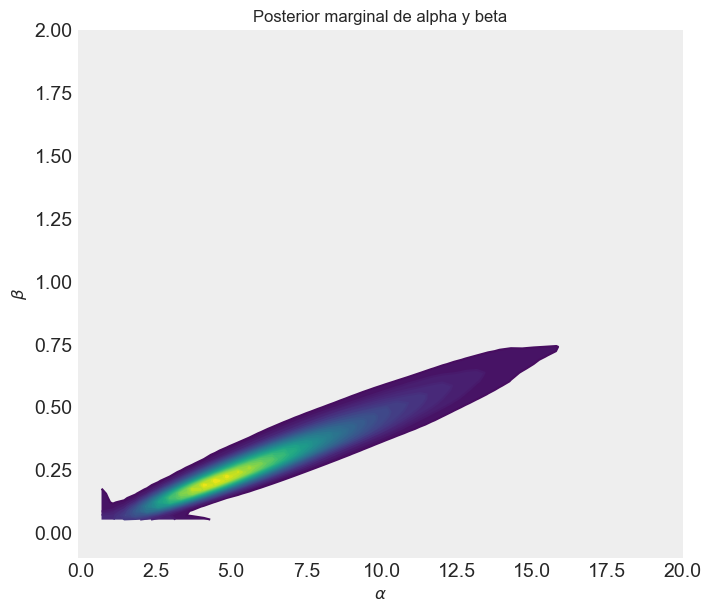

In [97]:
fig, ax = plt.subplots(figsize=(7, 6))
az.plot_kde(values=trace_bicis2['alpha'], values2=trace_bicis2['beta'], 
            ax=ax, contour=True, 
            contour_kwargs={'colors': None, "levels":30,  'cmap': 'viridis'},
            contourf_kwargs={"levels":30})
ax.set_xlim([-0.1,20]);
ax.set_ylim([-0.1,2]);
plt.xlabel(r'$\alpha$', fontsize = 12)
plt.ylabel(r'$\beta$', fontsize = 12)
plt.title('Posterior marginal de alpha y beta', fontsize = 12)

C:\ProgramData\Anaconda3\lib\site-packages\arviz\plots\jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:xlabel='alpha', ylabel='beta'>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


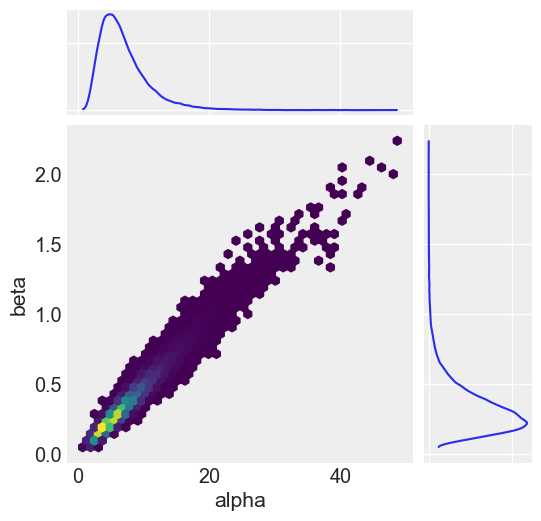

In [98]:
az.plot_joint(trace_bicis2,
            var_names=['alpha','beta'],
            kind='hexbin',
            figsize=(6, 6))

Por último comparamos ahora con los valores observados y el 95% de la distribución del posterior, agrupando la distribución de $\theta$ usando la mediana

Text(0, 0.5, '95% HDI de $\\theta_i$')

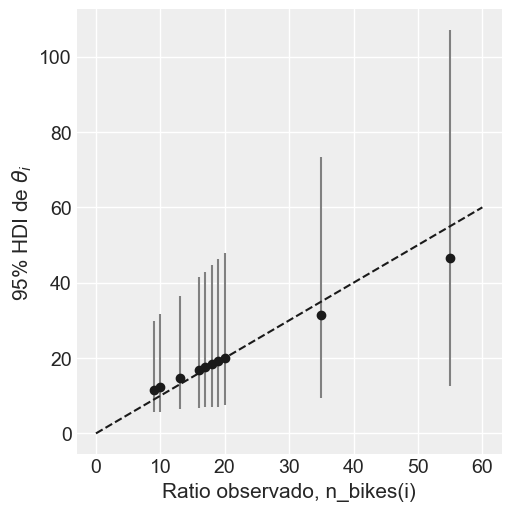

In [101]:
median_theta = np.median(trace_bicis2['theta'], axis=0)
hdi_ = az.hdi(trace_bicis2['theta'][None,:], hdi_prob=.95)

plt.figure(figsize=(5, 5))
plt.errorbar(bicis.loc[:, 'n_bikes'], median_theta, fmt='o',
             yerr=[hdi_[:, 0], hdi_[:, 1]], ecolor='gray', 
             markerfacecolor='k', mec='k')
plt.plot(np.linspace(0, 60, 10), np.linspace(0, 60, 10), 'k--')
plt.xlabel('Ratio observado, n_bikes(i)', fontsize = 15)
plt.ylabel(r'95% HDI de $\theta_i$', fontsize = 15)

A comparacion del caso anterior, en este caso estamos observando la cantidad promedio de Bicicletas que estan llegando. De nuevo parece ser que los datos combinan bien nuestra hipótesis y los observables.

In [102]:
e11 = ppe
#Bien. En la última gráfica hubieran extendido la línea punteada de identidad, para referencia. Ahí les hice un cambio para eso.


In [105]:
nota = e1 + e2 + e3 + e4 + e5 + e6 + e7 + e8 + e9 + e10 + e11
print("La nota en este taller es: ", round(nota, 2))

La nota en este taller es:  4.91


## ANEXOS

### EJERCICIO 3: Detector de Mentiras

In [ ]:
print("prop_tramposos")
#trampo=35
p_trace = burned_trace["prop_tramposos"]
plt.hist(p_trace, histtype="stepfilled", alpha=0.75, bins=30, 
         label="posterior distribution caso original", color="#348ABD")
plt.vlines(p_trace.mean(), 0, 9000, alpha=0.35)

#trampo=10
plt.hist(burned_trace_10["prop_tramposos"], histtype="stepfilled", alpha=0.5, bins=30, 
         label="posterior distribution trampo=10", color="red")
plt.vlines(burned_trace_10["prop_tramposos"].mean(), 0, 9000, alpha=0.35,color="red")
plt.vlines(p_trace.mean(), 0, 9000, alpha=0.35)

#trampo=25
plt.hist(burned_trace_25["prop_tramposos"], histtype="stepfilled", alpha=0.5, bins=30, 
         label="posterior distribution trampo=25", color="darkcyan")
plt.vlines(burned_trace_25["prop_tramposos"].mean(), 0, 9000, alpha=0.5,color="darkcyan")

#trampo=50
plt.hist(burned_trace_50["prop_tramposos"], histtype="stepfilled", alpha=0.5, bins=30, 
         label="posterior distribution trampo=50", color="navy")
plt.vlines(burned_trace_50["prop_tramposos"].mean(), 0, 9000, alpha=0.5,color="navy")

#trampo=90 (extreme)
plt.hist(burned_trace_extreme["prop_tramposos"], histtype="stepfilled", alpha=0.75, bins=30, 
         label="posterior distribution trampo=90", color="tomato")
plt.vlines(burned_trace_extreme["prop_tramposos"].mean(), 0, 9000, alpha=0.35,color="tomato")


plt.xlim(0.0, 1)


plt.legend(fontsize=10);

In [ ]:
print('MODENA CARGADA\n',az.summary(burned_trace_mc,kind='stats'))
print('MONEDA JUSTA\n',az.summary(burned_trace,kind='stats'))
#Forma pro
az.plot_posterior(burned_trace_mc,kind='hist',color="red")
az.plot_posterior(burned_trace,kind='hist')
print('El gráfico rojo corresponde a los valores calculados para la posterior en el caso moenda cargada', 
      '\nEl gráfico azul corresponde a los valores calculados para la posterior en el caso moneda justa')
az.style.use("arviz-darkgrid")

### EJERCICIO 4: Modelos Jerarquicos

In [ ]:
#SOLUCION
#(FORMA 2: Simular el proceso con un $\tau$ muy grande)
with pm.Model() as model_colegios_tau:
    mu = pm.Uniform('mu', 0, 30)
    tau = pm.Uniform('tau', 20, 30)    #cota de 20
    
    theta = pm.Normal('theta', mu=mu, sigma=tau, 
                      shape=schools.shape[0])

    y = pm.Normal('y', mu = theta, sigma = schools.loc[:,'SE'], 
                  observed = schools.loc[:,'Efecto'])
    
    # Sampleo
    trace_colegios_tau = pm.sample(5000, tune = 1000, target_accept = 0.99)
    posterior_predictive = pm.sample_posterior_predictive(trace_colegios)